# COMPARATIVE ANALYSIS OF THE CESIUM FEATURES FOR DIFFERENT SAMPLES

This Notebook compares the _cesium_ features for two different datasets. The most important comparison is the one between ML subsample and the synthetic S4 sample, because the ML model will be trained on the cesium features of S4 sample, and then applied to ML subsample to make predictions. All other comparisons (S1, S2, S3 samples, and pulsating/non-pulsating subsamples of S4) can be used as benchmark results.

**SOME IDEAS TO IMPLEMENT:**
- Distribuciones individuales:
  - Ajustar distribuciones para los valores de las diferentes features, individualmente: ¿salen las mismas distribuciones para los features entre S4 sample y ML subsample? ¿Con las mismas `location` y `scale`?
  - Hacer algún test estadístico que nos pueda indicar si las distribuciones son las mismas o no (ver libro Practical Statistics for Astromnomers).
  - Posible visualización: dos scatter plots de `loc` y `scale`: el color indicaría si se ha ajustado la misma distribución o no; el tamaño podría indicar en cierto modo las incertidumbres en los ajustes de distribuciones.
  - Si salieran muy diferentes, comparar también ML subsample con los subconjuntos de pulsantes y no-pulsantes.
- Correlación entre pares de features:
    - Calcular las matrices de correlación entre las features, individualmente para ML subsample y para S4 sample.
    - Comparar ambas matricas (¿división element-wise?)
    - Visualización: heatmap.




## Modules and configuration

### Modules

In [126]:
import pandas as pd
import numpy as np

import pickle

from IPython.display import clear_output

from scipy.stats import mannwhitneyu, kstest, ks_2samp, anderson_ksamp

from distfit import distfit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [127]:
# CONFIGURATION:
ID_0 = "CARMENES ML subsample"
ID_1 = "S1 sample"
ID_2 = "S2 sample"
ID_3 = "S3 sample"
ID_4 = "S4 sample"
ID_4P = "S4 sample - Only pulsating stars"
ID_4NP = "S4 sample - Only non-pulsating stars"

DATAFILE_0 = "../data/DATASETS_CESIUM/cesium_ML_Subsample_Dataset.csv"
DATAFILE_1 = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S1.csv"
DATAFILE_2 = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S2.csv"
DATAFILE_3 = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S3.csv"
DATAFILE_4 = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S4.csv"

RESULTS_FILE = "../data/Cesium_Features_Distributions_Analysis.csv"
RELIABLE_FEATURES_FILE = "../data/REL_Cesium_Features_Distributions_Analysis.csv"
UNRELIABLE_FEATURES_FILE = "../data/UNREL_Cesium_Features_Distributions_Analysis.csv"
REL_FEATURES_LIST_OUT = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"
UNREL_FEATURES_LIST_OUT = "../data/ML_MODELS/ML_pipeline_steps/Unreliable_features.pickle"

CORR_ML_FILE = "../data/Cesium_Corr_ML.csv"
CORR_S4_FILE = "../data/Cesium_Corr_S4.csv"
CORR_S4P_FILE = "../data/Cesium_Corr_S4P.csv"
CORR_S4NP_FILE = "../data/Cesium_Corr_S4NP.csv"
COMP_CORR_S4_ML_FILE = "../data/Cesium_CompareCorr_ML_S4.csv"
COMP_CORR_P_NP_FILE = "../data/Cesium_CompareCorr_S4P_S4NP.csv"

IMG_FOLDER = "./img/"
DIST_IMG_FOLDER_1 = "./img/d_comp_ML_S4/"
DIST_IMG_FOLDER_2 = "./img/d_comp_ML_S4_P-NP/"
DIST_IMG_FOLDER_3 = "./img/d_comp_P-NP/"


METADATA_0 = ['Karmn', 'SpT', 'SpTnum', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'L_Lsol', 'eL_Lsol',
              'R_Rsol', 'eR_Rsol', 'M_Msol', 'eM_Msol', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'pi_mas',
              'epi_mas', 'd_pc', 'ed_pc', 'Vr_kms-1', 'eVr_kms-1', 'ruwe', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1',
              'W_kms-1', 'eW_kms-1', 'sa_m/s/a', 'esa_m/s/a', 'Pop', 'vsini_flag', 'vsini_kms-1', 'P_d',
              'pEWHalpha_A', 'epEWHalpha_A', 'Activity', 'FUV_mag', 'eFUV_mag', 'NUV_mag', 'eNUV_mag', 'u_mag', 'eu_mag',
              'BT_mag', 'eBT_mag', 'B_mag', 'eB_mag', 'BP_mag', 'eBP_mag', 'g_mag', 'eg_mag', 'VT_mag', 'eVT_mag',
              'V_mag', 'eV_mag', 'Ra_mag', 'r_mag', 'er_mag', 'GG_mag', 'eGG_mag', 'i_mag', 'ei_mag', 'RP_mag', 'eRP_mag',
              'IN_mag', 'J_mag', 'eJ_mag', 'H_mag', 'eH_mag', 'Ks_mag', 'eKs_mag', 'QFlag_2M', 'W1_mag', 'eW1_mag',
              'W2_mag', 'eW2_mag', 'W3_mag', 'eW3_mag', 'W4_mag', 'eW4_mag', 'QFlag_WISE', 'Multiplicity',
              'Planet', 'PlanetNum', 'Teff_min_K', 'Teff_max_K', 'logg_min', 'logg_max', 'is_GTO',
              'InstBand_nominal', 'InstBand_ranged']
METADATA_1 = ['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase',
              'S1_Ps', 'S1_Tobs']
METADATA_2 = ['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase',
              'S1_Ps', 'S1_Tobs',
              'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale',
              'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev']
METADATA_3 = ['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase',
              'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints']
METADATA_4 = ['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase',
              'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints',
              'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale',
              'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev']

ALL_CS_FEATURES = ['all_times_nhist_numpeaks',
                   'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin',
                   'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
                   'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
                   'all_times_nhist_peak_3_to_4',
                   'all_times_nhist_peak_val',
                   'avg_double_to_single_step', 'avg_err', 'avgt',
                   'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50',
                   'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000',
                   'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000',
                   'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000',
                   'cads_avg', 'cads_med', 'cads_std', 'mean',
                   'med_double_to_single_step', 'med_err',
                   'n_epochs', 'std_double_to_single_step', 'std_err',
                   'total_time', 'amplitude',
                   'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50',
                   'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80',
                   'max_slope', 'maximum', 'median', 'median_absolute_deviation', 'minimum',
                   'percent_amplitude', 'percent_beyond_1_std', 'percent_close_to_median', 'percent_difference_flux_percentile',
                   'period_fast', 'qso_log_chi2_qsonu', 'qso_log_chi2nuNULL_chi2nu', 'skew', 'std',
                   'stetson_j', 'stetson_k', 'weighted_average', 'fold2P_slope_10percentile', 'fold2P_slope_90percentile',
                   'freq1_amplitude1', 'freq1_amplitude2', 'freq1_amplitude3', 'freq1_amplitude4',
                   'freq1_freq', 'freq1_lambda', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq1_signif',
                   'freq2_amplitude1', 'freq2_amplitude2', 'freq2_amplitude3', 'freq2_amplitude4',
                   'freq2_freq', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4',
                   'freq3_amplitude1', 'freq3_amplitude2', 'freq3_amplitude3', 'freq3_amplitude4',
                   'freq3_freq', 'freq3_rel_phase2', 'freq3_rel_phase3', 'freq3_rel_phase4',
                   'freq_amplitude_ratio_21', 'freq_amplitude_ratio_31',
                   'freq_frequency_ratio_21', 'freq_frequency_ratio_31',
                   'freq_model_max_delta_mags', 'freq_model_min_delta_mags', 'freq_model_phi1_phi2',
                   'freq_n_alias', 'freq_signif_ratio_21', 'freq_signif_ratio_31',
                   'freq_varrat', 'freq_y_offset', 'linear_trend', 'medperc90_2p_p',
                   'p2p_scatter_2praw', 'p2p_scatter_over_mad', 'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
                   'scatter_res_raw']

SIGNIFICANCE_LEVEL = 0.05 # alpha value (a p-value less that this will lead us to reject the null hypothesis)


### Functions

In [128]:
def compare_dist(d1, d2, d1_label, d2_label, varname=None, fig_title=None, fig_filename=None, kde=False, conf_level=0.95):
    '''Plots and saves overlapped histograms.
    It also shows the result of three statistical tests: t-Student, Wilcoxon-Mann-Whitney U, Kolmogorov-Smirnov,
    according to the confidence level passed as parameter: 'conf_level', which is equal to (1-'alpha').
    '''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': True},
                  kde_kws={'linewidth': 2})
    plt.figure(figsize=(10,7))
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    #plt.grid(axis='x', alpha=0.75)
    plt.ylabel('Frequency of occurrence', fontsize=12)
    ax1 = sns.distplot(d1, label=d1_label, **kwargs)
    ax2 = sns.distplot(d2, label=d2_label, **kwargs)
    if varname is None:
        ax1.set_xlabel("%s / %s" %(d1_label, d2_label), fontsize=12)
    else:
        ax1.set_xlabel(varname, fontsize=12)
    #plt.xlim(0,100)
    if kde == False:
        ax1.get_lines()[0].remove()
        ax2.get_lines()[0].remove()
    #plt.legend(loc='upper right');
    plt.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')
    # Perform the t-Student, Wilcoxon-Mann-Whitney U, and Kolmogorov-Smirnov tests (as independent samples):
    # REMOVED THE t-Student TEST, AS IT ASSUMES EQUAL VARIANCES.
    #print("t-Student test results:")
    #t_stat, t_p = ttest_ind(d1, d2)
    #if t_p > (1 - conf_level):
    #    t_result = "Probably same mean value"
    #else:
    #    t_result = "***Probably different mean values"
    #print('\t%s: t=%.3f, p-value=%.3f' % (t_result, t_stat, t_p))
    print("Wilcoxon-Mann-Whitley U test results:")
    wmw_stat, wmw_p = mannwhitneyu(d1, d2, nan_policy='omit')
    if wmw_p > (1 - conf_level):
        wmw_result = "Probably the same distribution"
    else:
        wmw_result = "***Probably different distributions"
    print('\t%s: U=%.3f, p-value=%.3f' % (wmw_result, wmw_stat, wmw_p))
    ks_stat, ks_p = kstest(d1, d2)
    if ks_p > (1 - conf_level):
        ks_result = "Probably the same distribution"
    else:
        ks_result = "***Probably different distributions"
    print('\t%s: D=%.3f, p-value=%.3f' % (ks_result, ks_stat, ks_p))
    

In [129]:
def multi_compare_dist(d_list, d_labels, varname=None, fig_title=None, fig_filename=None,
                       kde=False, hist=False, hist_fill=True):
    '''Plots and saves multiple overlapped histograms.'''
    # Plots and saves the figure
    if kde == True:
        if hist == True:
            kind = 'hist'
            kde = True
        elif hist == False:
            kind = 'kde'
    else:
        if hist == True:
            kind = 'hist'
            kde = False
        else:
            # None, defaulting to both.
            print("*WARNING: neither 'kde' nor 'hist' are set to 'True'. Defaulting to plotting both...")
            kind = 'hist'
            kde = True
        
    kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
                  kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,7))
    axes = []
    for i in range(0, len(d_list)):
        new_axis= sns.distplot(d_list[i], label=d_labels[i], kde=kde, **kwargs)
        #new_axis = sns.displot(d_list[i], label=d_labels[i], kind=kind, kde=kde)
        axes.append(new_axis)
        #if kde == False:
        #    axes[i].get_lines()[0].remove()
    if varname is None:
        axes[0].set_xlabel("%s / %s" %(d1_label, d2_label), fontsize=12)
    else:
        axes[0].set_xlabel(varname, fontsize=12)
    #plt.xlim(0,100)
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    #plt.grid(axis='x', alpha=0.75)
    plt.ylabel('Frequency of occurrence', fontsize=12)
    #plt.legend(loc='upper right');
    plt.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')


In [130]:
def draw_heatmap(data, fig_title=None, xlabel=None, ylabel=None, xsize=None, ysize=None, fig_filename=None, kwargs={}):
    '''Plots a heatmap, setting the title and saving the figure to disk if needed'''
    plt.figure(figsize=(10,7))
    if xsize is None:
        xsize = 'small'
    plt.xticks(fontsize=xsize)
    if ysize is None:
        ysize = 'small'
    plt.yticks(fontsize=ysize)
    sns.heatmap(data, **kwargs)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if fig_title is None:
        plt.title("Heatmap")
    else:
        plt.title(fig_title)
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg')


## Data loading

### Load ML subsample

In [131]:
ml = pd.read_csv(DATAFILE_0, sep=',', decimal='.')
ml.head()

,Karmn,SpT,SpTnum,Teff_K,eTeff_K,logg,elogg,[Fe/H],e[Fe/H],L_Lsol,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,J23505-095,M4.0 V,4.0,3377.0,34.0,4.83,0.10,-0.08,0.10,0.010298,...,0.813481,0.554379,0.489066,0.004200,1.295720,1.436865,0.920684,1.092416,0.978539,0.445028
1,J23492+024,M1.0 V,1.0,3573.0,23.0,4.94,0.13,-0.55,0.08,0.025559,...,0.707163,0.879691,-0.910369,0.000814,1.044964,1.000000,0.935512,0.935512,1.242137,0.829985
2,J23431+365,M4.0 V,4.0,3301.0,30.0,5.18,0.12,-0.10,0.10,0.005663,...,0.991922,0.222404,0.082574,0.000863,1.033456,0.496443,1.216607,0.641686,1.907862,0.091860
3,J23419+441,M5.0 V,5.0,3186.0,41.0,5.15,0.18,0.04,0.17,0.002349,...,0.733129,0.550059,0.182636,-0.001152,1.053811,0.971801,0.921956,0.994958,1.188842,0.546181
4,J23381-162,M2.0 V,2.0,3570.0,22.0,5.07,0.12,-0.35,0.08,0.019451,...,0.872267,0.684783,-0.039567,0.001306,1.099656,1.011043,1.268031,1.157254,2.078314,0.457373


In [132]:
ml.shape

(233, 208)

In [133]:
print(list(ml.columns))

['Karmn', 'SpT', 'SpTnum', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'L_Lsol', 'eL_Lsol', 'R_Rsol', 'eR_Rsol', 'M_Msol', 'eM_Msol', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'pi_mas', 'epi_mas', 'd_pc', 'ed_pc', 'Vr_kms-1', 'eVr_kms-1', 'ruwe', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'sa_m/s/a', 'esa_m/s/a', 'Pop', 'vsini_flag', 'vsini_kms-1', 'P_d', 'pEWHalpha_A', 'epEWHalpha_A', 'Activity', 'FUV_mag', 'eFUV_mag', 'NUV_mag', 'eNUV_mag', 'u_mag', 'eu_mag', 'BT_mag', 'eBT_mag', 'B_mag', 'eB_mag', 'BP_mag', 'eBP_mag', 'g_mag', 'eg_mag', 'VT_mag', 'eVT_mag', 'V_mag', 'eV_mag', 'Ra_mag', 'r_mag', 'er_mag', 'GG_mag', 'eGG_mag', 'i_mag', 'ei_mag', 'RP_mag', 'eRP_mag', 'IN_mag', 'J_mag', 'eJ_mag', 'H_mag', 'eH_mag', 'Ks_mag', 'eKs_mag', 'QFlag_2M', 'W1_mag', 'eW1_mag', 'W2_mag', 'eW2_mag', 'W3_mag', 'eW3_mag', 'W4_mag', 'eW4_mag', 'QFlag_WISE', 'Multiplicity', 'Planet', 'PlanetNum', 'Teff_min_K', 'Teff_max_K', 'logg_min', 'logg

### Load S1 sample

In [134]:
s1 = pd.read_csv(DATAFILE_1, sep=',', decimal='.')
s1.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,S1_Tobs,VALID_RECORD,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,0.0016,100.0,True,...,NaN,0.001326,0.000129,3.293653e-06,0.999228,0.001738,0.098765,0.000000,0.010797,0.006487
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,0.0016,100.0,True,...,NaN,0.005260,0.000327,-9.058920e-06,0.999019,0.119301,0.152174,0.119565,0.022471,0.012361
2,Star-00002,False,0.00,0.00,0.0,2.457549e+06,0.00,0.0016,100.0,True,...,NaN,NaN,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
3,Star-00003,False,0.00,0.00,0.0,2.457460e+06,0.00,0.0016,100.0,True,...,NaN,NaN,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,0.0016,100.0,True,...,NaN,0.000020,0.000044,1.980618e-08,1.000139,0.000082,0.281250,0.000000,0.082948,0.003679


In [135]:
s1.shape

(1000, 122)

In [136]:
print(list(s1.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S1_Ps', 'S1_Tobs', 'VALID_RECORD', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'mean', 'med_double_to_single_step', 'med_err', 'n_epochs', 'std_double_to_single_step', 'std_err', 'total_time', 'amplitude', 'flux

### Load S2 sample

In [137]:
s2 = pd.read_csv(DATAFILE_2, sep=',', decimal='.')
s2.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,S1_Tobs,S2_errorRV_dist_idx,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,0.0016,100.0,209,...,NaN,0.746107,-0.004695,-0.000475,1.000531,0.999364,1.256637,1.247788,1.588497,0.851964
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,0.0016,100.0,78,...,NaN,0.720200,0.001579,-0.000594,1.000788,0.982691,1.219512,1.211382,1.539695,0.828415
2,Star-00002,False,0.00,0.00,0.0,2.457549e+06,0.00,0.0016,100.0,218,...,0.842302,0.999342,-0.000008,0.000104,1.000366,0.995855,1.445652,1.456522,2.002502,1.002956
3,Star-00003,False,0.00,0.00,0.0,2.457460e+06,0.00,0.0016,100.0,28,...,0.830507,0.999045,0.000036,-0.000348,0.999962,0.991204,1.512931,1.500000,2.013441,0.996601
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,0.0016,100.0,6,...,NaN,0.780079,-0.001185,-0.000273,1.001060,1.000005,1.265957,1.265957,1.620227,0.877818


In [138]:
s2.shape

(1000, 129)

In [139]:
print(list(s2.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S1_Ps', 'S1_Tobs', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev', 'VALID_RECORD', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', '

### Load S3 sample

In [140]:
s3 = pd.read_csv(DATAFILE_3, sep=',', decimal='.')
s3.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S3_sampling_idx,S3_Tobs,S3_Ps_mean,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,59,1581.730057,158.173006,...,1.001269,0.021240,0.057225,0.000034,2.764199,0.989516,0.965517,0.264368,1.381216,0.013698
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,129,816.772693,13.389716,...,0.753011,0.003942,0.001563,-0.000086,0.736545,0.066700,0.881988,0.074534,1.597621,0.018230
2,Star-00002,False,0.00,0.00,0.0,2.457549e+06,0.00,119,1822.043054,28.031432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Star-00003,False,0.00,0.00,0.0,2.457460e+06,0.00,65,1890.807762,37.074662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,144,2088.089735,90.786510,...,0.869865,0.000205,-0.024793,0.000024,1.494358,0.207057,1.012346,0.074074,2.217589,0.002778


In [141]:
s3.shape

(1000, 126)

In [142]:
print(list(s3.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'VALID_RECORD', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'mean', 'med_double_to_single_step', 'med_err', 'n_epochs', '

### Load S4 sample

In [143]:
s4 = pd.read_csv(DATAFILE_4, sep=',', decimal='.')
s4.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S3_sampling_idx,S3_Tobs,S3_Ps_mean,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,59,1581.730057,158.173006,...,0.991610,0.194021,0.126036,0.000540,1.178827,0.703403,1.725000,0.775000,2.721112,0.038931
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,129,816.772693,13.389716,...,1.003992,0.609698,0.014987,0.001951,1.106382,1.229017,1.122677,0.959108,1.308700,0.304471
2,Star-00002,False,0.00,0.00,0.0,2.457549e+06,0.00,119,1822.043054,28.031432,...,0.934956,0.632319,-0.026237,-0.000212,1.158086,0.661486,1.981735,1.150685,2.052008,0.572111
3,Star-00003,False,0.00,0.00,0.0,2.457460e+06,0.00,65,1890.807762,37.074662,...,0.962051,0.581716,-0.113978,-0.000015,1.221266,0.789303,1.187817,1.096447,2.098036,0.321233
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,144,2088.089735,90.786510,...,0.925290,0.222879,0.466669,-0.000863,0.883003,0.474592,1.746193,0.893401,2.259602,0.189422


In [144]:
s4.shape

(1000, 133)

In [145]:
print(list(s4.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'VALID_RECORD', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_p

#### Separate S4 pulsating and non-pulsating stars

In [146]:
s4p = s4[s4['Pulsating'] == True].copy()
s4p.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S3_sampling_idx,S3_Tobs,S3_Ps_mean,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,59,1581.730057,158.173006,...,0.991610,0.194021,0.126036,0.000540,1.178827,0.703403,1.725000,0.775000,2.721112,0.038931
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,129,816.772693,13.389716,...,1.003992,0.609698,0.014987,0.001951,1.106382,1.229017,1.122677,0.959108,1.308700,0.304471
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,144,2088.089735,90.786510,...,0.925290,0.222879,0.466669,-0.000863,0.883003,0.474592,1.746193,0.893401,2.259602,0.189422
12,Star-00012,True,60.83,1.44,0.0,2.457407e+06,0.10,8,1186.771330,18.258020,...,1.040576,0.682003,-0.263269,-0.001673,0.993025,0.750616,1.564706,1.600000,2.272948,0.588490
15,Star-00015,True,17.00,0.13,0.0,2.457443e+06,0.11,37,1394.021606,60.609635,...,0.932474,0.230892,-0.156019,0.000096,1.328868,0.305082,1.961039,1.363636,2.233477,0.179074


In [147]:
s4p.shape

(104, 133)

In [148]:
s4np = s4[s4['Pulsating'] == False].copy()
s4np.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S3_sampling_idx,S3_Tobs,S3_Ps_mean,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
2,Star-00002,False,0.0,0.0,0.0,2.457549e+06,0.0,119,1822.043054,28.031432,...,0.934956,0.632319,-0.026237,-0.000212,1.158086,0.661486,1.981735,1.150685,2.052008,0.572111
3,Star-00003,False,0.0,0.0,0.0,2.457460e+06,0.0,65,1890.807762,37.074662,...,0.962051,0.581716,-0.113978,-0.000015,1.221266,0.789303,1.187817,1.096447,2.098036,0.321233
5,Star-00005,False,0.0,0.0,0.0,2.457419e+06,0.0,59,1581.730057,158.173006,...,1.060312,0.078105,0.394298,-0.000343,1.761679,0.397730,1.178571,1.116071,2.024744,0.046395
6,Star-00006,False,0.0,0.0,0.0,2.457545e+06,0.0,151,734.966250,183.741562,...,1.239898,0.071569,0.198211,0.002397,1.376864,1.309492,1.216912,1.448529,2.775065,0.075165
7,Star-00007,False,0.0,0.0,0.0,2.457574e+06,0.0,126,693.066220,63.006020,...,0.914068,0.188807,0.374903,0.002247,0.897846,0.380062,1.771429,1.142857,1.985114,0.142359


In [149]:
s4np.shape

(896, 133)

In [150]:
print("Ratio of pulsating stars in S4 sample: %.1f %%" %(100.0 * len(s4p) / len(s4)))

Ratio of pulsating stars in S4 sample: 10.4 %


## Basic analysis

We do here a quick inspection of _cesium_ features for both datasets.

### Count of `Nan` values and ratios

In [151]:
df_list = [s1, s2, s3, s4, ml, s4p, s4np]
case_list = [ID_1, ID_2, ID_3, ID_4, ID_0, ID_4P, ID_4NP]
nan_count = None
for i in range(0, len(df_list)):
    nan_count_new = df_list[i][ALL_CS_FEATURES].isna().sum()
    nan_count_new = pd.DataFrame(nan_count_new[nan_count_new > 0]) \
        .reset_index() \
        .rename(columns={'index': 'Cesium feature', 0: 'NaN count'})
    nan_count_new.insert(loc=0, column='Sample', value=case_list[i])
    nan_count_new['NaN ratio'] = np.round(nan_count_new['NaN count'] / len(df_list[i]), decimals=3)
    if nan_count is None:
        nan_count = nan_count_new.copy()
    else:
        nan_count = pd.concat([nan_count, nan_count_new], ignore_index=True)
nan_count

,Sample,Cesium feature,NaN count,NaN ratio
0,S1 sample,all_times_nhist_peak1_bin,1000,1.000
1,S1 sample,all_times_nhist_peak2_bin,1000,1.000
2,S1 sample,all_times_nhist_peak3_bin,1000,1.000
3,S1 sample,all_times_nhist_peak4_bin,1000,1.000
4,S1 sample,all_times_nhist_peak_1_to_2,1000,1.000
...,...,...,...,...
144,S4 sample - Only non-pulsating stars,all_times_nhist_peak_2_to_4,64,0.071
145,S4 sample - Only non-pulsating stars,all_times_nhist_peak_3_to_4,64,0.071
146,S4 sample - Only non-pulsating stars,fold2P_slope_10percentile,11,0.012
147,S4 sample - Only non-pulsating stars,fold2P_slope_90percentile,11,0.012


Let's check the results for each sample:

In [152]:
# ML subsample:
nan_count[nan_count['Sample'] == ID_0]

,Sample,Cesium feature,NaN count,NaN ratio
113,CARMENES ML subsample,all_times_nhist_peak2_bin,3,0.013
114,CARMENES ML subsample,all_times_nhist_peak3_bin,8,0.034
115,CARMENES ML subsample,all_times_nhist_peak4_bin,16,0.069
116,CARMENES ML subsample,all_times_nhist_peak_1_to_2,3,0.013
117,CARMENES ML subsample,all_times_nhist_peak_1_to_3,8,0.034
118,CARMENES ML subsample,all_times_nhist_peak_1_to_4,16,0.069
119,CARMENES ML subsample,all_times_nhist_peak_2_to_3,8,0.034
120,CARMENES ML subsample,all_times_nhist_peak_2_to_4,16,0.069
121,CARMENES ML subsample,all_times_nhist_peak_3_to_4,16,0.069
122,CARMENES ML subsample,fold2P_slope_10percentile,5,0.021


In [153]:
# S4 sample:
nan_count[nan_count['Sample'] == ID_4]

,Sample,Cesium feature,NaN count,NaN ratio
101,S4 sample,all_times_nhist_peak2_bin,17,0.017
102,S4 sample,all_times_nhist_peak3_bin,40,0.040
103,S4 sample,all_times_nhist_peak4_bin,74,0.074
104,S4 sample,all_times_nhist_peak_1_to_2,17,0.017
105,S4 sample,all_times_nhist_peak_1_to_3,40,0.040
106,S4 sample,all_times_nhist_peak_1_to_4,74,0.074
107,S4 sample,all_times_nhist_peak_2_to_3,40,0.040
108,S4 sample,all_times_nhist_peak_2_to_4,74,0.074
109,S4 sample,all_times_nhist_peak_3_to_4,74,0.074
110,S4 sample,fold2P_slope_10percentile,13,0.013


**OBSERVATION:** two interesting things:

- For the two more relevant samples, the ratio of missing values is not very high.
- More interestingly, comparing ML subsample with S4 sample, the features that yield `NaN` values are exactly the same ones. Besides, the ratios on `NaN` are very similar between the two samples, for each of these features.

This means that, in terms of _cesium_ features that yield `NaN` values, the samples are pretty similar to each other.

We can also have a look at the `NaN` results for the other samples:

In [154]:
# S4 sample - Only pulsating stars
nan_count[nan_count['Sample'] == ID_4P]

,Sample,Cesium feature,NaN count,NaN ratio
125,S4 sample - Only pulsating stars,all_times_nhist_peak2_bin,1,0.010
126,S4 sample - Only pulsating stars,all_times_nhist_peak3_bin,2,0.019
127,S4 sample - Only pulsating stars,all_times_nhist_peak4_bin,10,0.096
128,S4 sample - Only pulsating stars,all_times_nhist_peak_1_to_2,1,0.010
129,S4 sample - Only pulsating stars,all_times_nhist_peak_1_to_3,2,0.019
130,S4 sample - Only pulsating stars,all_times_nhist_peak_1_to_4,10,0.096
131,S4 sample - Only pulsating stars,all_times_nhist_peak_2_to_3,2,0.019
132,S4 sample - Only pulsating stars,all_times_nhist_peak_2_to_4,10,0.096
133,S4 sample - Only pulsating stars,all_times_nhist_peak_3_to_4,10,0.096
134,S4 sample - Only pulsating stars,fold2P_slope_10percentile,2,0.019


In [155]:
# S4 sample - Only non-pulsating stars:
nan_count[nan_count['Sample'] == ID_4NP]

,Sample,Cesium feature,NaN count,NaN ratio
137,S4 sample - Only non-pulsating stars,all_times_nhist_peak2_bin,16,0.018
138,S4 sample - Only non-pulsating stars,all_times_nhist_peak3_bin,38,0.042
139,S4 sample - Only non-pulsating stars,all_times_nhist_peak4_bin,64,0.071
140,S4 sample - Only non-pulsating stars,all_times_nhist_peak_1_to_2,16,0.018
141,S4 sample - Only non-pulsating stars,all_times_nhist_peak_1_to_3,38,0.042
142,S4 sample - Only non-pulsating stars,all_times_nhist_peak_1_to_4,64,0.071
143,S4 sample - Only non-pulsating stars,all_times_nhist_peak_2_to_3,38,0.042
144,S4 sample - Only non-pulsating stars,all_times_nhist_peak_2_to_4,64,0.071
145,S4 sample - Only non-pulsating stars,all_times_nhist_peak_3_to_4,64,0.071
146,S4 sample - Only non-pulsating stars,fold2P_slope_10percentile,11,0.012


**OBSERVATION:** There are some features for which the `NaN` ratio is more similar between ML subsample and the pulsating stars of S4 sample, while for other features, ther is more similar ratios between ML subsample and the non-pulsating stars of S4 sample.

In [156]:
# S1 sample:
nan_count[nan_count['Sample'] == ID_1]

,Sample,Cesium feature,NaN count,NaN ratio
0,S1 sample,all_times_nhist_peak1_bin,1000,1.000
1,S1 sample,all_times_nhist_peak2_bin,1000,1.000
2,S1 sample,all_times_nhist_peak3_bin,1000,1.000
3,S1 sample,all_times_nhist_peak4_bin,1000,1.000
4,S1 sample,all_times_nhist_peak_1_to_2,1000,1.000
5,S1 sample,all_times_nhist_peak_1_to_3,1000,1.000
6,S1 sample,all_times_nhist_peak_1_to_4,1000,1.000
7,S1 sample,all_times_nhist_peak_2_to_3,1000,1.000
8,S1 sample,all_times_nhist_peak_2_to_4,1000,1.000
9,S1 sample,all_times_nhist_peak_3_to_4,1000,1.000


**OBSERVATION:** Many features with high `NaN` ratios for S1 sample. Probably because of the perfect shape of these signals.

In [157]:
# S2 sample:
nan_count[nan_count['Sample'] == ID_2]

,Sample,Cesium feature,NaN count,NaN ratio
30,S2 sample,all_times_nhist_peak1_bin,1000,1.000
31,S2 sample,all_times_nhist_peak2_bin,1000,1.000
32,S2 sample,all_times_nhist_peak3_bin,1000,1.000
33,S2 sample,all_times_nhist_peak4_bin,1000,1.000
34,S2 sample,all_times_nhist_peak_1_to_2,1000,1.000
35,S2 sample,all_times_nhist_peak_1_to_3,1000,1.000
36,S2 sample,all_times_nhist_peak_1_to_4,1000,1.000
37,S2 sample,all_times_nhist_peak_2_to_3,1000,1.000
38,S2 sample,all_times_nhist_peak_2_to_4,1000,1.000
39,S2 sample,all_times_nhist_peak_3_to_4,1000,1.000


**OBSERVATION:** there are less features with `NaN` values, but for some of them the ratio is 1.0 (all RV curves yield `NaN` values for these features.

In [158]:
# S3 sample:
nan_count[nan_count['Sample'] == ID_3]

,Sample,Cesium feature,NaN count,NaN ratio
44,S3 sample,all_times_nhist_peak2_bin,17,0.017
45,S3 sample,all_times_nhist_peak3_bin,40,0.040
46,S3 sample,all_times_nhist_peak4_bin,74,0.074
47,S3 sample,all_times_nhist_peak_1_to_2,17,0.017
48,S3 sample,all_times_nhist_peak_1_to_3,40,0.040
49,S3 sample,all_times_nhist_peak_1_to_4,74,0.074
50,S3 sample,all_times_nhist_peak_2_to_3,40,0.040
51,S3 sample,all_times_nhist_peak_2_to_4,74,0.074
52,S3 sample,all_times_nhist_peak_3_to_4,74,0.074
53,S3 sample,flux_percentile_ratio_mid20,896,0.896


**OBSERVATION:** even more features ($\sim50$) yield `NaN` values for S3 sample, and with very high ratios.

### Count of `inf` values and ratios

In [159]:
np.isinf(ml[ALL_CS_FEATURES]).sum()

all_times_nhist_numpeaks      0
all_times_nhist_peak1_bin     0
all_times_nhist_peak2_bin     0
all_times_nhist_peak3_bin     0
all_times_nhist_peak4_bin     0
                             ..
p2p_scatter_2praw             0
p2p_scatter_over_mad          0
p2p_scatter_pfold_over_mad    0
p2p_ssqr_diff_over_var        0
scatter_res_raw               0
Length: 112, dtype: int64

In [160]:
inf_count = None
for i in range(0, len(df_list)):
    #np.isinf(df['data'])
    inf_count_new = np.isinf(df_list[i][ALL_CS_FEATURES]).sum()
    inf_count_new = pd.DataFrame(inf_count_new[inf_count_new > 0]) \
        .reset_index() \
        .rename(columns={'index': 'Cesium feature', 0: 'inf count'})
    inf_count_new.insert(loc=0, column='Sample', value=case_list[i])
    inf_count_new['inf ratio'] = np.round(inf_count_new['inf count'] / len(df_list[i]), decimals=3)
    if inf_count is None:
        inf_count = inf_count_new.copy()
    else:
        inf_count = pd.concat([inf_count, inf_count_new], ignore_index=True)
inf_count

,Sample,Cesium feature,inf count,inf ratio
0,S1 sample,avg_double_to_single_step,1000,1.000
1,S1 sample,med_double_to_single_step,677,0.677
2,S1 sample,qso_log_chi2nuNULL_chi2nu,896,0.896
3,S2 sample,avg_double_to_single_step,1000,1.000
4,S2 sample,med_double_to_single_step,677,0.677
5,S3 sample,qso_log_chi2_qsonu,3,0.003
6,S3 sample,qso_log_chi2nuNULL_chi2nu,893,0.893


**OBSERVATION:** No `Inf` values at all in S4 sample or ML subsample. Only a few features show infinite values for samples S1, S2 and S3 (although in that caste, the ratios of infinite values are very high.

### Basic statistics

In [161]:
basic_stats = None
for i in range(0, len(df_list)):
    basic_stats_new = df_list[i][ALL_CS_FEATURES] \
        .describe() \
        .T \
        .reset_index(drop=False) \
        .rename(columns={'index': 'Cesium feature'})
    basic_stats_new.insert(loc=0, column='Sample', value=case_list[i])
    if basic_stats is None:
        basic_stats = basic_stats_new.copy()
    else:
        basic_stats = pd.concat([basic_stats, basic_stats_new], ignore_index=True)
basic_stats

,Sample,Cesium feature,count,mean,std,min,25%,50%,75%,max
0,S1 sample,all_times_nhist_numpeaks,1000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,S1 sample,all_times_nhist_peak1_bin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S1 sample,all_times_nhist_peak2_bin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S1 sample,all_times_nhist_peak3_bin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S1 sample,all_times_nhist_peak4_bin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
779,S4 sample - Only non-pulsating stars,p2p_scatter_2praw,896.0,0.784714,0.372845,0.188155,0.596124,0.740925,0.909902,7.008911
780,S4 sample - Only non-pulsating stars,p2p_scatter_over_mad,896.0,1.679670,0.971247,0.346491,1.353432,1.538017,1.815486,24.000000
781,S4 sample - Only non-pulsating stars,p2p_scatter_pfold_over_mad,896.0,1.358475,1.101318,0.284211,1.029140,1.244671,1.448716,24.000000
782,S4 sample - Only non-pulsating stars,p2p_ssqr_diff_over_var,896.0,2.057316,0.444622,0.420203,1.817267,2.014959,2.254427,4.345226


**IMPORTANT NOTE:** From now on, we will focus in the comparison of ML subsample and S4 sample.

## Feature values statistical distributions analysis (ML subsample and S4 sample)

We now compare the distributions of the values for each features between ML subsample and S4 sample.

The first aim is to answer this question for each feature: can the feature values extracted separately from ML subsample and S4 sample belong to the same distribution?

Our null hypothesis is $H_{0}$: "The values from ML subsample and S4 sample come from the same distribution". The alternative hypothesis is $H_{1}$: "The values from ML subsample and S4 sample come from different distributions". The significance level of choice is $95\%$, i.e. $\alpha=0.05$.

To answer the question, we use the Wilcoxon-Mann-Whitney U test and the Kolmogorov-Smirnov test for each of the features.

### First, one example

We first see an example over the first _cesium_ feature to see how these tests operate and how to interpret them.

#### Example - Wilcoxon-Mann-Whitney U test

We can use the default values for the parameters of `mannwhitneyu` function, but we specify them for further clarity. The exception is the parameter `nan_policy`: as we have seen, for both ML subsample and S4 sample we have certain `NaN` values present in the data, so we want to get rid of them for this calculation (as there are not many of them: $\sim7\%$
 at most), and set that parameter to "omit".

In [162]:
mannwhitneyu(ml['all_times_nhist_numpeaks'], s4['all_times_nhist_numpeaks'],
             use_continuity=True, alternative='two-sided',
             axis=0, method='auto', nan_policy='omit', keepdims=False)

MannwhitneyuResult(statistic=120782.0, pvalue=0.3793471784708963)

In [163]:
mannwhitneyu(s4['all_times_nhist_numpeaks'], ml['all_times_nhist_numpeaks'],
             use_continuity=True, alternative='two-sided',
             axis=0, method='auto', nan_policy='omit', keepdims=False)

MannwhitneyuResult(statistic=112218.0, pvalue=0.3793471784708963)

The `pvalue` is higher than $0.05$. Hence, we cannot reject the null hypotesis. Although we cannot affirm that the null hypothesis is true, with this `p-value` we can _assume_ $H_{0}$ to be true, instead of the alternative $H_{1}$ to be true.

The `statistic`value in this case equals the sum of the rankings of the values in `x` sample (in this case, the ML subsample). Not an easy value to interpret directly.

Notice how the `statistic` value is not the same for both calculations above, it depends on the order of the parameters passed to the function (i.e. which one of the two samples we name as `x` and as `y`). however, the values returned for `pvalue` are equal.

#### Example - Kolmogorov-Smirnov 2-sample test

In [164]:
kstest(ml['all_times_nhist_numpeaks'], s4['all_times_nhist_numpeaks'],
       alternative='two-sided', method='auto')

KstestResult(statistic=0.03522317596566524, pvalue=0.9654117599720415)

In [165]:
kstest(s4['all_times_nhist_numpeaks'], ml['all_times_nhist_numpeaks'],
       alternative='two-sided', method='auto')

KstestResult(statistic=0.03522317596566524, pvalue=0.9654117599720415)

Again, the `pvalue` is higher than $0.05$. Hence, we cannot reject the null hypotesis, and we _could assume_ that the two samples come from the same distribution.

Notice that in this case, the statistic value is just the maximum difference between the Cumulative Distribution Function (CDF) of ML subsample and S4 sample, which is easily interpretable, and has a low value of $\sim0.04$.

In this case, the returned value for `statistic` is the same, no matter the order of which samples are passed as `x` and `y`. The returned values of `pvalue` are also the same.

#### Example - Kolmogorov-Smirnov 2-sample test (alternative function)

Should yield the same results as those using `kstest`.

In [166]:
ks_2samp(ml['all_times_nhist_numpeaks'], s4['all_times_nhist_numpeaks'],
         alternative='two-sided', method='auto')

KstestResult(statistic=0.03522317596566524, pvalue=0.9654117599720415)

In [167]:
ks_2samp(s4['all_times_nhist_numpeaks'], ml['all_times_nhist_numpeaks'],
         alternative='two-sided', method='auto')

KstestResult(statistic=0.03522317596566524, pvalue=0.9654117599720415)

As expected, it yields exactly the same value as before, as `kstest` and `ks_2samp` are equivalent for this case.

#### Example - Anderson-Darling 2-sample test

In [168]:
anderson_ksamp([ml['all_times_nhist_numpeaks'], s4['all_times_nhist_numpeaks']], midrank=True)

Anderson_ksampResult(statistic=-0.668456324343198, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

In [169]:
anderson_ksamp([s4['all_times_nhist_numpeaks'], ml['all_times_nhist_numpeaks']], midrank=True)

Anderson_ksampResult(statistic=-0.668456324343198, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

**Note:** in this version of the test, the significance level returned (the _p-value_) is capped at 0.1% and 25%.

Again, the `pvalue` is higher than $0.05$. Hence, we cannot reject the null hypotesis, and we _could assume_ that the two samples come from the same distribution.

In this case also, the returned value for `statistic` is the same, no matter the order of which samples are passed as `x` and `y`. The returned values of `pvalue` are also the same.

### Statistical tests for all the features

We now apply both tests to each of the _cesium_ features, comparing ML subsample and S4 sample, and also the pulsating stars in S4 sample with the non-pulsating stars in S4 sample.

For both tests we record both the `pvalue` and the `statistic` values, even thougn for Wilcoxon-Mann-Whiltley case the `statistic` has no immediate interpretation by itself (much more easy to interpret in the case of the Kolmogorov-Smirnov test.

We store all these test results in a pandas DataFrame.

In [170]:
ml_s4_comp = dict({'Feature': [],
                   'WMW_U': [], 'WMW_pvalue': [],
                   'KS_D': [], 'KS_pvalue': [],
                   'AD_A': [], 'AD_pvalue(capped)': [],
                   'PNP_WMW_U': [], 'PNP_WMW_pvalue': [],
                   'PNP_KS_D': [], 'PNP_KS_pvalue': [],
                   'PNP_AD_A': [], 'PNP_AD_pvalue(capped)': []})
for feature in ALL_CS_FEATURES:
    ml_s4_comp['Feature'].append(feature)
    # ML vs S4:
    wmw_result = mannwhitneyu(ml[feature], s4[feature],
                              use_continuity=True, alternative='two-sided',
                              axis=0, method='auto', nan_policy='omit', keepdims=False)
    ml_s4_comp['WMW_U'].append(wmw_result.statistic)
    ml_s4_comp['WMW_pvalue'].append(wmw_result.pvalue)
    ks_result = kstest(ml[feature], s4[feature],
                       alternative='two-sided', method='auto')
    ml_s4_comp['KS_D'].append(ks_result.statistic)
    ml_s4_comp['KS_pvalue'].append(ks_result.pvalue)
    try:
        ad_result = anderson_ksamp([ml[feature], s4[feature]],
                                   midrank=True)
        ml_s4_comp['AD_A'].append(ad_result.statistic)
        ml_s4_comp['AD_pvalue(capped)'].append(ad_result.significance_level)
    except Exception as e:
        print("*WARNING: failed ML/S4 AD test for feature '%s'. Error: %s" %(feature, str(e)))
        ml_s4_comp['AD_A'].append(np.nan)
        ml_s4_comp['AD_pvalue(capped)'].append(0.5)
    
    # Pulsating vs non-pulsating:
    wmw_result = mannwhitneyu(s4p[feature], s4np[feature],
                              use_continuity=True, alternative='two-sided',
                              axis=0, method='auto', nan_policy='omit', keepdims=False)
    ml_s4_comp['PNP_WMW_U'].append(wmw_result.statistic)
    ml_s4_comp['PNP_WMW_pvalue'].append(wmw_result.pvalue)
    ks_result = kstest(s4p[feature], s4np[feature],
                       alternative='two-sided', method='auto')
    ml_s4_comp['PNP_KS_D'].append(ks_result.statistic)
    ml_s4_comp['PNP_KS_pvalue'].append(ks_result.pvalue)
    try:
        ad_result = anderson_ksamp([s4p[feature], s4np[feature]],
                                   midrank=True)
        ml_s4_comp['PNP_AD_A'].append(ad_result.statistic)
        ml_s4_comp['PNP_AD_pvalue(capped)'].append(ad_result.significance_level)
    except Exception as e:
        print("*WARNING: failed P/NP AD test for feature '%s'. Error: %s" %(feature, str(e)))
        ml_s4_comp['PNP_AD_A'].append(np.nan)
        ml_s4_comp['PNP_AD_pvalue(capped)'].append(0.5)

ml_s4_comp = pd.DataFrame(ml_s4_comp)
ml_s4_comp

*WARNING: failed ML/S4 AD test for feature 'cad_probs_1'. Error: anderson_ksamp needs more than one distinct observation
*WARNING: failed P/NP AD test for feature 'cad_probs_1'. Error: anderson_ksamp needs more than one distinct observation
*WARNING: failed ML/S4 AD test for feature 'cad_probs_5000000'. Error: anderson_ksamp needs more than one distinct observation
*WARNING: failed P/NP AD test for feature 'cad_probs_5000000'. Error: anderson_ksamp needs more than one distinct observation
*WARNING: failed ML/S4 AD test for feature 'cad_probs_10000000'. Error: anderson_ksamp needs more than one distinct observation
*WARNING: failed P/NP AD test for feature 'cad_probs_10000000'. Error: anderson_ksamp needs more than one distinct observation


,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
0,all_times_nhist_numpeaks,120782.0,3.793472e-01,0.035223,9.654118e-01,-0.668456,0.250000,41294.0,0.056156,0.114784,0.157900,1.926957,0.052183
1,all_times_nhist_peak1_bin,114581.5,6.949720e-01,0.022953,9.999161e-01,-1.140590,0.250000,52231.5,0.042966,0.100532,0.282348,1.956274,0.050768
2,all_times_nhist_peak2_bin,107056.0,2.103276e-01,0.051648,6.715164e-01,-0.090395,0.250000,44097.0,0.653723,0.061212,0.852996,-0.249196,0.250000
3,all_times_nhist_peak3_bin,106151.5,6.890811e-01,0.027485,9.979828e-01,-1.063720,0.250000,42598.5,0.661427,0.075292,0.636367,-0.324552,0.250000
4,all_times_nhist_peak4_bin,101541.0,8.068785e-01,0.015155,1.000000e+00,-1.246351,0.250000,43153.5,0.099353,0.105254,0.234976,1.289896,0.095560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,p2p_scatter_2praw,150216.0,5.663501e-12,0.302768,7.941054e-16,42.684180,0.001000,45292.5,0.641272,0.068595,0.744574,-0.769719,0.250000
108,p2p_scatter_over_mad,67319.0,9.443367e-24,0.397691,2.538640e-27,89.577543,0.001000,47409.5,0.769492,0.056319,0.911300,-0.964418,0.250000
109,p2p_scatter_pfold_over_mad,104825.0,1.707774e-02,0.109060,2.042568e-02,2.972474,0.019962,45865.0,0.794417,0.060096,0.867464,-0.913553,0.250000
110,p2p_ssqr_diff_over_var,63880.0,5.936770e-27,0.427193,1.304499e-31,97.297129,0.001000,48566.0,0.479040,0.096755,0.324889,-0.136372,0.250000


**IMPORTANT OBSERVATION:** Ok, we clearly see (in the last rows) that for some of the features, the results of the test will tell us that the values of some features taken from ML subsample and S4 sample do **not** come from the same population.

For the comparison between pulsating and non-pulsating stars, it is not so clear.

### Add a feature ID (for reference purposes only)

In [171]:
ml_s4_comp.reset_index(inplace=True)
ml_s4_comp.head()

,index,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
0,0,all_times_nhist_numpeaks,120782.0,0.379347,0.035223,0.965412,-0.668456,0.25,41294.0,0.056156,0.114784,0.157900,1.926957,0.052183
1,1,all_times_nhist_peak1_bin,114581.5,0.694972,0.022953,0.999916,-1.140590,0.25,52231.5,0.042966,0.100532,0.282348,1.956274,0.050768
2,2,all_times_nhist_peak2_bin,107056.0,0.210328,0.051648,0.671516,-0.090395,0.25,44097.0,0.653723,0.061212,0.852996,-0.249196,0.250000
3,3,all_times_nhist_peak3_bin,106151.5,0.689081,0.027485,0.997983,-1.063720,0.25,42598.5,0.661427,0.075292,0.636367,-0.324552,0.250000
4,4,all_times_nhist_peak4_bin,101541.0,0.806879,0.015155,1.000000,-1.246351,0.25,43153.5,0.099353,0.105254,0.234976,1.289896,0.095560


In [172]:
ml_s4_comp.rename(columns={'index': 'Feature_ID'}, inplace=True)
ml_s4_comp.head()

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
0,0,all_times_nhist_numpeaks,120782.0,0.379347,0.035223,0.965412,-0.668456,0.25,41294.0,0.056156,0.114784,0.157900,1.926957,0.052183
1,1,all_times_nhist_peak1_bin,114581.5,0.694972,0.022953,0.999916,-1.140590,0.25,52231.5,0.042966,0.100532,0.282348,1.956274,0.050768
2,2,all_times_nhist_peak2_bin,107056.0,0.210328,0.051648,0.671516,-0.090395,0.25,44097.0,0.653723,0.061212,0.852996,-0.249196,0.250000
3,3,all_times_nhist_peak3_bin,106151.5,0.689081,0.027485,0.997983,-1.063720,0.25,42598.5,0.661427,0.075292,0.636367,-0.324552,0.250000
4,4,all_times_nhist_peak4_bin,101541.0,0.806879,0.015155,1.000000,-1.246351,0.25,43153.5,0.099353,0.105254,0.234976,1.289896,0.095560


In [173]:
ml_s4_comp['Feature_ID'] = ml_s4_comp['Feature_ID'] \
    .map(lambda x: str(x).zfill(3))
ml_s4_comp.head()

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
0,000,all_times_nhist_numpeaks,120782.0,0.379347,0.035223,0.965412,-0.668456,0.25,41294.0,0.056156,0.114784,0.157900,1.926957,0.052183
1,001,all_times_nhist_peak1_bin,114581.5,0.694972,0.022953,0.999916,-1.140590,0.25,52231.5,0.042966,0.100532,0.282348,1.956274,0.050768
2,002,all_times_nhist_peak2_bin,107056.0,0.210328,0.051648,0.671516,-0.090395,0.25,44097.0,0.653723,0.061212,0.852996,-0.249196,0.250000
3,003,all_times_nhist_peak3_bin,106151.5,0.689081,0.027485,0.997983,-1.063720,0.25,42598.5,0.661427,0.075292,0.636367,-0.324552,0.250000
4,004,all_times_nhist_peak4_bin,101541.0,0.806879,0.015155,1.000000,-1.246351,0.25,43153.5,0.099353,0.105254,0.234976,1.289896,0.095560


### Checking the features with failed tests (ML subsample vs S4 sample)

Let's see which ones are those (would be those for which `p-value` is less than $0.05$, which would lead us to reject the null hypothesis $H_{0}$)

#### Features failing the Wilcoxon-Mann-Whitley test

In [174]:
wmw_fail = ml_s4_comp[ml_s4_comp['WMW_pvalue'] < SIGNIFICANCE_LEVEL]
wmw_fail

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
35,035,mean,137387.0,1.981356e-05,0.170021,3.013092e-05,11.924888,0.001000,48146.0,0.577388,0.069454,7.309641e-01,-0.528128,0.250000
40,040,std_err,131898.0,1.657390e-03,0.139579,1.115966e-03,7.626565,0.001000,39896.5,0.016335,0.150412,2.623906e-02,3.119855,0.017489
42,042,amplitude,191585.0,4.176242e-53,0.535451,1.523724e-50,159.596830,0.001000,46133.5,0.869515,0.062157,8.402903e-01,-0.423514,0.250000
43,043,flux_percentile_ratio_mid20,48647.0,1.078705e-43,0.517824,4.228246e-47,132.345281,0.001000,47023.0,0.877286,0.033310,9.998466e-01,-1.098477,0.250000
44,044,flux_percentile_ratio_mid35,49052.0,3.404774e-43,0.472116,7.745472e-39,129.997736,0.001000,47925.0,0.632695,0.060354,8.641929e-01,-0.845851,0.250000
45,045,flux_percentile_ratio_mid50,54717.0,1.601624e-36,0.429236,6.383108e-32,108.893239,0.001000,48759.0,0.437116,0.070484,7.144691e-01,-0.618205,0.250000
46,046,flux_percentile_ratio_mid65,66898.0,3.932470e-24,0.361901,1.393131e-22,69.064387,0.001000,48751.0,0.438811,0.077181,6.056392e-01,-0.601204,0.250000
47,047,flux_percentile_ratio_mid80,80558.0,2.094465e-13,0.251313,5.443258e-11,35.443516,0.001000,49569.0,0.285701,0.092205,3.816257e-01,-0.165292,0.250000
48,048,max_slope,129038.0,1.042714e-02,0.092644,7.253271e-02,4.195939,0.006820,46924.0,0.905354,0.071085,7.048050e-01,-0.291129,0.250000
49,049,maximum,189394.0,3.730689e-50,0.504657,1.267068e-44,155.301534,0.001000,46168.0,0.879266,0.066363,7.792093e-01,-0.474617,0.250000


In [175]:
len(wmw_fail)

56

#### Features failing the Kolmogorov-Smirnov test

In [176]:
ks_fail = ml_s4_comp[ml_s4_comp['KS_pvalue'] < SIGNIFICANCE_LEVEL]
ks_fail

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
13,013,avg_err,123830.0,1.342967e-01,0.123914,5.423224e-03,3.878581,0.008964,42064.5,0.104434,0.098558,0.304064,1.049588,0.120519
14,014,avgt,124735.0,9.251904e-02,0.106820,2.455578e-02,2.752296,0.024359,46342.0,0.928693,0.085422,0.476759,-0.905499,0.250000
35,035,mean,137387.0,1.981356e-05,0.170021,3.013092e-05,11.924888,0.001000,48146.0,0.577388,0.069454,0.730964,-0.528128,0.250000
40,040,std_err,131898.0,1.657390e-03,0.139579,1.115966e-03,7.626565,0.001000,39896.5,0.016335,0.150412,0.026239,3.119855,0.017489
42,042,amplitude,191585.0,4.176242e-53,0.535451,1.523724e-50,159.596830,0.001000,46133.5,0.869515,0.062157,0.840290,-0.423514,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,p2p_scatter_2praw,150216.0,5.663501e-12,0.302768,7.941054e-16,42.684180,0.001000,45292.5,0.641272,0.068595,0.744574,-0.769719,0.250000
108,108,p2p_scatter_over_mad,67319.0,9.443367e-24,0.397691,2.538640e-27,89.577543,0.001000,47409.5,0.769492,0.056319,0.911300,-0.964418,0.250000
109,109,p2p_scatter_pfold_over_mad,104825.0,1.707774e-02,0.109060,2.042568e-02,2.972474,0.019962,45865.0,0.794417,0.060096,0.867464,-0.913553,0.250000
110,110,p2p_ssqr_diff_over_var,63880.0,5.936770e-27,0.427193,1.304499e-31,97.297129,0.001000,48566.0,0.479040,0.096755,0.324889,-0.136372,0.250000


In [177]:
len(ks_fail)

62

#### Features failing the Wilcoxon-Mann-Whitley test

In [178]:
ad_fail = ml_s4_comp[ml_s4_comp['AD_pvalue(capped)'] < SIGNIFICANCE_LEVEL]
ad_fail

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
13,013,avg_err,123830.0,1.342967e-01,0.123914,5.423224e-03,3.878581,0.008964,42064.5,0.104434,0.098558,0.304064,1.049588,0.120519
14,014,avgt,124735.0,9.251904e-02,0.106820,2.455578e-02,2.752296,0.024359,46342.0,0.928693,0.085422,0.476759,-0.905499,0.250000
35,035,mean,137387.0,1.981356e-05,0.170021,3.013092e-05,11.924888,0.001000,48146.0,0.577388,0.069454,0.730964,-0.528128,0.250000
37,037,med_err,125000.0,8.248455e-02,0.091326,7.950952e-02,2.074541,0.045454,43631.5,0.288352,0.085422,0.476759,0.317036,0.250000
40,040,std_err,131898.0,1.657390e-03,0.139579,1.115966e-03,7.626565,0.001000,39896.5,0.016335,0.150412,0.026239,3.119855,0.017489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,p2p_scatter_2praw,150216.0,5.663501e-12,0.302768,7.941054e-16,42.684180,0.001000,45292.5,0.641272,0.068595,0.744574,-0.769719,0.250000
108,108,p2p_scatter_over_mad,67319.0,9.443367e-24,0.397691,2.538640e-27,89.577543,0.001000,47409.5,0.769492,0.056319,0.911300,-0.964418,0.250000
109,109,p2p_scatter_pfold_over_mad,104825.0,1.707774e-02,0.109060,2.042568e-02,2.972474,0.019962,45865.0,0.794417,0.060096,0.867464,-0.913553,0.250000
110,110,p2p_ssqr_diff_over_var,63880.0,5.936770e-27,0.427193,1.304499e-31,97.297129,0.001000,48566.0,0.479040,0.096755,0.324889,-0.136372,0.250000


In [179]:
len(ad_fail)

64

#### Features failing all tests

In [180]:
all_fail = ml_s4_comp[(ml_s4_comp['WMW_pvalue'] < SIGNIFICANCE_LEVEL) & \
                       (ml_s4_comp['KS_pvalue'] < SIGNIFICANCE_LEVEL)]
all_fail

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
35,035,mean,137387.0,1.981356e-05,0.170021,3.013092e-05,11.924888,0.001000,48146.0,0.577388,0.069454,7.309641e-01,-0.528128,0.250000
40,040,std_err,131898.0,1.657390e-03,0.139579,1.115966e-03,7.626565,0.001000,39896.5,0.016335,0.150412,2.623906e-02,3.119855,0.017489
42,042,amplitude,191585.0,4.176242e-53,0.535451,1.523724e-50,159.596830,0.001000,46133.5,0.869515,0.062157,8.402903e-01,-0.423514,0.250000
43,043,flux_percentile_ratio_mid20,48647.0,1.078705e-43,0.517824,4.228246e-47,132.345281,0.001000,47023.0,0.877286,0.033310,9.998466e-01,-1.098477,0.250000
44,044,flux_percentile_ratio_mid35,49052.0,3.404774e-43,0.472116,7.745472e-39,129.997736,0.001000,47925.0,0.632695,0.060354,8.641929e-01,-0.845851,0.250000
45,045,flux_percentile_ratio_mid50,54717.0,1.601624e-36,0.429236,6.383108e-32,108.893239,0.001000,48759.0,0.437116,0.070484,7.144691e-01,-0.618205,0.250000
46,046,flux_percentile_ratio_mid65,66898.0,3.932470e-24,0.361901,1.393131e-22,69.064387,0.001000,48751.0,0.438811,0.077181,6.056392e-01,-0.601204,0.250000
47,047,flux_percentile_ratio_mid80,80558.0,2.094465e-13,0.251313,5.443258e-11,35.443516,0.001000,49569.0,0.285701,0.092205,3.816257e-01,-0.165292,0.250000
49,049,maximum,189394.0,3.730689e-50,0.504657,1.267068e-44,155.301534,0.001000,46168.0,0.879266,0.066363,7.792093e-01,-0.474617,0.250000
51,051,median_absolute_deviation,209438.0,2.194969e-80,0.713661,6.796136e-95,282.555646,0.001000,47161.5,0.838282,0.069969,7.227490e-01,-0.682772,0.250000


In [181]:
len(all_fail)

55

#### Features failing any test

In [182]:
any_fail = ml_s4_comp[(ml_s4_comp['WMW_pvalue'] < SIGNIFICANCE_LEVEL) | \
                      (ml_s4_comp['KS_pvalue'] < SIGNIFICANCE_LEVEL) |
                      (ml_s4_comp['AD_pvalue(capped)'] < SIGNIFICANCE_LEVEL)]
any_fail

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
13,013,avg_err,123830.0,1.342967e-01,0.123914,5.423224e-03,3.878581,0.008964,42064.5,0.104434,0.098558,0.304064,1.049588,0.120519
14,014,avgt,124735.0,9.251904e-02,0.106820,2.455578e-02,2.752296,0.024359,46342.0,0.928693,0.085422,0.476759,-0.905499,0.250000
35,035,mean,137387.0,1.981356e-05,0.170021,3.013092e-05,11.924888,0.001000,48146.0,0.577388,0.069454,0.730964,-0.528128,0.250000
37,037,med_err,125000.0,8.248455e-02,0.091326,7.950952e-02,2.074541,0.045454,43631.5,0.288352,0.085422,0.476759,0.317036,0.250000
40,040,std_err,131898.0,1.657390e-03,0.139579,1.115966e-03,7.626565,0.001000,39896.5,0.016335,0.150412,0.026239,3.119855,0.017489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,p2p_scatter_2praw,150216.0,5.663501e-12,0.302768,7.941054e-16,42.684180,0.001000,45292.5,0.641272,0.068595,0.744574,-0.769719,0.250000
108,108,p2p_scatter_over_mad,67319.0,9.443367e-24,0.397691,2.538640e-27,89.577543,0.001000,47409.5,0.769492,0.056319,0.911300,-0.964418,0.250000
109,109,p2p_scatter_pfold_over_mad,104825.0,1.707774e-02,0.109060,2.042568e-02,2.972474,0.019962,45865.0,0.794417,0.060096,0.867464,-0.913553,0.250000
110,110,p2p_ssqr_diff_over_var,63880.0,5.936770e-27,0.427193,1.304499e-31,97.297129,0.001000,48566.0,0.479040,0.096755,0.324889,-0.136372,0.250000


In [183]:
len(any_fail)

64

In [184]:
any_fail.describe()

,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
count,64.000000,6.400000e+01,64.000000,6.400000e+01,64.000000,64.000000,64.000000,64.000000,64.000000,6.400000e+01,64.000000,64.000000
mean,133051.734375,3.791237e-02,0.315469,4.532913e-03,79.111087,0.003233,47274.117188,0.461881,0.096368,4.748623e-01,0.785090,0.192043
std,46626.229930,1.276531e-01,0.201771,1.435339e-02,95.786916,0.006929,3871.127404,0.312397,0.043292,3.137694e-01,2.790766,0.092154
min,48647.000000,2.156720e-115,0.091326,9.235845e-176,2.074541,0.001000,36832.000000,0.000001,0.033310,5.756972e-07,-1.098477,0.001000
25%,95921.000000,1.390553e-36,0.150749,2.251483e-32,10.335921,0.001000,45339.000000,0.174807,0.069239,2.201005e-01,-0.621387,0.130871
50%,127944.500000,5.062895e-09,0.267000,2.725606e-11,39.332641,0.001000,47285.500000,0.479485,0.085379,4.774044e-01,-0.203392,0.250000
75%,169474.250000,4.048654e-03,0.433942,3.556965e-04,109.300117,0.001000,48796.875000,0.735999,0.106885,7.343666e-01,0.965879,0.250000
max,228266.000000,7.455738e-01,0.909498,7.950952e-02,427.842256,0.045454,60010.000000,0.972389,0.280391,9.998466e-01,15.804428,0.250000


In [185]:
unrel_features = any_fail['Feature'].to_list()
print(unrel_features)

['avg_err', 'avgt', 'mean', 'med_err', 'std_err', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'max_slope', 'maximum', 'median', 'median_absolute_deviation', 'minimum', 'percent_amplitude', 'percent_close_to_median', 'percent_difference_flux_percentile', 'period_fast', 'qso_log_chi2_qsonu', 'qso_log_chi2nuNULL_chi2nu', 'skew', 'std', 'stetson_j', 'stetson_k', 'weighted_average', 'fold2P_slope_10percentile', 'fold2P_slope_90percentile', 'freq1_amplitude1', 'freq1_amplitude2', 'freq1_amplitude3', 'freq1_amplitude4', 'freq1_freq', 'freq1_lambda', 'freq1_signif', 'freq2_amplitude1', 'freq2_amplitude2', 'freq2_amplitude3', 'freq2_amplitude4', 'freq2_freq', 'freq3_amplitude1', 'freq3_amplitude2', 'freq3_amplitude3', 'freq3_amplitude4', 'freq3_freq', 'freq_amplitude_ratio_21', 'freq_amplitude_ratio_31', 'freq_frequency_ratio_21', 'freq_frequency_ratio_31', 'freq_model_max

**IMPORTANT OBSERVATION**: indeed, these are a lot of features not passing the tests.

Let's see which features pass both tests.

#### Features passing all tests

In [186]:
all_pass = ml_s4_comp[(ml_s4_comp['WMW_pvalue'] >= SIGNIFICANCE_LEVEL) & \
                      (ml_s4_comp['KS_pvalue'] >= SIGNIFICANCE_LEVEL) & \
                      (ml_s4_comp['AD_pvalue(capped)'] >= SIGNIFICANCE_LEVEL)]
all_pass

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
0,000,all_times_nhist_numpeaks,120782.0,0.379347,0.035223,0.965412,-0.668456,0.250000,41294.0,0.056156,0.114784,0.157900,1.926957,0.052183
1,001,all_times_nhist_peak1_bin,114581.5,0.694972,0.022953,0.999916,-1.140590,0.250000,52231.5,0.042966,0.100532,0.282348,1.956274,0.050768
2,002,all_times_nhist_peak2_bin,107056.0,0.210328,0.051648,0.671516,-0.090395,0.250000,44097.0,0.653723,0.061212,0.852996,-0.249196,0.250000
3,003,all_times_nhist_peak3_bin,106151.5,0.689081,0.027485,0.997983,-1.063720,0.250000,42598.5,0.661427,0.075292,0.636367,-0.324552,0.250000
4,004,all_times_nhist_peak4_bin,101541.0,0.806879,0.015155,1.000000,-1.246351,0.250000,43153.5,0.099353,0.105254,0.234976,1.289896,0.095560
5,005,all_times_nhist_peak_1_to_2,111338.0,0.720849,0.024438,0.999710,-1.145389,0.250000,47354.5,0.454990,0.069626,0.728218,-0.631012,0.250000
6,006,all_times_nhist_peak_1_to_3,104684.0,0.472886,0.048635,0.740615,-0.587674,0.250000,47488.0,0.158786,0.092291,0.380512,-0.276310,0.250000
7,007,all_times_nhist_peak_1_to_4,96684.0,0.386845,0.043721,0.844377,-0.610713,0.250000,41927.0,0.250715,0.091432,0.391853,0.347375,0.240314
8,008,all_times_nhist_peak_2_to_3,104802.5,0.487681,0.033176,0.980196,-0.735724,0.250000,45527.5,0.502819,0.068681,0.743206,-0.871108,0.250000
9,009,all_times_nhist_peak_2_to_4,96329.5,0.343964,0.039227,0.919987,-0.628204,0.250000,41104.5,0.415710,0.109718,0.195913,0.271599,0.250000


In [187]:
len(all_pass)

48

In [188]:
all_pass.describe()

,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
count,48.000000,48.000000,48.000000,48.000000,45.000000,48.000000,48.000000,48.000000,48.000000,48.000000,45.000000,48.000000
mean,114296.656250,0.640502,0.030476,0.923157,-0.802935,0.264817,45825.000000,0.467152,0.076209,0.588626,0.266172,0.219739
std,6278.878762,0.213743,0.014924,0.147577,0.400312,0.061621,2653.865372,0.306771,0.027977,0.268915,1.142111,0.105852
min,96329.500000,0.173409,0.000000,0.253125,-1.246351,0.211198,41104.500000,0.030095,0.000000,0.070025,-1.152248,0.004951
25%,114285.500000,0.487219,0.022262,0.908019,-1.134345,0.250000,43922.500000,0.205624,0.066964,0.389018,-0.531858,0.147033
50%,116295.500000,0.666077,0.029955,0.993441,-0.850179,0.250000,45744.000000,0.442105,0.075421,0.634268,-0.187864,0.250000
75%,118205.500000,0.799733,0.040015,0.999936,-0.610713,0.250000,47525.000000,0.688945,0.091647,0.769958,0.848824,0.250000
max,122997.000000,1.000000,0.072901,1.000000,0.477408,0.500000,52231.500000,1.000000,0.132126,1.000000,4.573360,0.500000


In [1]:
rel_features = all_pass['Feature'].to_list()
print(rel_features)

NameError: name 'all_pass' is not defined

**IMPORTANT OBSERVATION:** Hence, more than one half of the features do not pass at least one of the tests (and many of those fail both tests). This would mean that the values for those features present in ML subsample and S4 sample do **not** come from the same population. Than means that those characteristics in S4 sample are somehow incorrectly simulated, for whatever reason.

A first intuition would be leave the  $64$ _dubious_ features out of the ML process and train the model using just those $48$ features for which both the Wilcoxon-Mann-Whitley test and the Kolmogorov-Smirnov tests are passed.

Anyway, to further confirm this extent, we will draw comparative distributions (histograms) for each of the features.

### Fitting distributions

We now try to fit distributions for the values of each feature, separately for ML subsample and S4 sample, then comparing both (i.e. check if they are the same or not) and also comparing their basic parameters (`scale` and `location`), giving a relative error for each of those.

In [190]:
ml_s4_comp

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,PNP_KS_D,PNP_KS_pvalue,PNP_AD_A,PNP_AD_pvalue(capped)
0,000,all_times_nhist_numpeaks,120782.0,3.793472e-01,0.035223,9.654118e-01,-0.668456,0.250000,41294.0,0.056156,0.114784,0.157900,1.926957,0.052183
1,001,all_times_nhist_peak1_bin,114581.5,6.949720e-01,0.022953,9.999161e-01,-1.140590,0.250000,52231.5,0.042966,0.100532,0.282348,1.956274,0.050768
2,002,all_times_nhist_peak2_bin,107056.0,2.103276e-01,0.051648,6.715164e-01,-0.090395,0.250000,44097.0,0.653723,0.061212,0.852996,-0.249196,0.250000
3,003,all_times_nhist_peak3_bin,106151.5,6.890811e-01,0.027485,9.979828e-01,-1.063720,0.250000,42598.5,0.661427,0.075292,0.636367,-0.324552,0.250000
4,004,all_times_nhist_peak4_bin,101541.0,8.068785e-01,0.015155,1.000000e+00,-1.246351,0.250000,43153.5,0.099353,0.105254,0.234976,1.289896,0.095560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,p2p_scatter_2praw,150216.0,5.663501e-12,0.302768,7.941054e-16,42.684180,0.001000,45292.5,0.641272,0.068595,0.744574,-0.769719,0.250000
108,108,p2p_scatter_over_mad,67319.0,9.443367e-24,0.397691,2.538640e-27,89.577543,0.001000,47409.5,0.769492,0.056319,0.911300,-0.964418,0.250000
109,109,p2p_scatter_pfold_over_mad,104825.0,1.707774e-02,0.109060,2.042568e-02,2.972474,0.019962,45865.0,0.794417,0.060096,0.867464,-0.913553,0.250000
110,110,p2p_ssqr_diff_over_var,63880.0,5.936770e-27,0.427193,1.304499e-31,97.297129,0.001000,48566.0,0.479040,0.096755,0.324889,-0.136372,0.250000


In [191]:
# NOTE - Not a very efficient way of doing this, but the number of items in the loop are few (only 112).
num_features = len(ml_s4_comp)
for i in range(0, num_features):
    clear_output(wait=True)
    feature = ml_s4_comp.loc[i, 'Feature']
    print("Fitting distributions for '%s' feature (%d of %d)..." %(feature, i + 1, num_features))

    # Fit ML subsample distribution:
    print("Fitting distributions for ML subsample...")
    dist = distfit()
    dist.fit_transform(ml[feature].dropna())
    ml_s4_comp.loc[i, 'CARMENES_dist_name'] = dist.model['name']
    ml_s4_comp.loc[i, 'CARMENES_dist_loc'] = dist.model['loc']
    ml_s4_comp.loc[i, 'CARMENES_dist_scale'] = dist.model['scale']

    # Fit S4 sample distribution:
    print("Fitting distributions for S4 sample...")
    dist = distfit()
    dist.fit_transform(s4[feature].dropna())
    ml_s4_comp.loc[i, 'S4_dist_name'] = dist.model['name']
    ml_s4_comp.loc[i, 'S4_dist_loc'] = dist.model['loc']
    ml_s4_comp.loc[i, 'S4_dist_scale'] = dist.model['scale']
    
# Now compare both distributions for all distributions:
print("\nComparing both fits for all features...")
# Distribution types:
ml_s4_comp['Same distribution'] = \
ml_s4_comp['S4_dist_name'] == ml_s4_comp['CARMENES_dist_name']
# 'loc' value:
ml_s4_comp['loc_rel_error'] = \
(ml_s4_comp['S4_dist_loc'] - ml_s4_comp['CARMENES_dist_loc']) / ml_s4_comp['CARMENES_dist_loc']
# Correct if 'CARMENES_dist_loc' is 0:
ml_s4_comp.loc[ml_s4_comp['CARMENES_dist_loc'] == 0 , 'loc_rel_error'] = \
    ml_s4_comp.loc[ml_s4_comp['CARMENES_dist_loc'] == 0 , 'S4_dist_loc']
# 'scale' value:
ml_s4_comp['scale_rel_error'] = \
    (ml_s4_comp['S4_dist_scale'] - ml_s4_comp['CARMENES_dist_scale']) / ml_s4_comp['CARMENES_dist_scale']
# Correct if 'CARMENES_dist_scale' is 0:
ml_s4_comp.loc[ml_s4_comp['CARMENES_dist_scale'] == 0 , 'scale_rel_error'] = \
    ml_s4_comp.loc[ml_s4_comp['CARMENES_dist_scale'] == 0 , 'S4_dist_scale']

print("\n--- COMPLETED ---")
    

Fitting distributions for 'scatter_res_raw' feature (112 of 112)...
Fitting distributions for ML subsample...
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.0 sec] [RSS: 14.9528098] [loc=0.345 scale=0.231]
[distfit] >[expon     ] [0.00 sec] [RSS: 13.2224843] [loc=0.020 scale=0.324]
[distfit] >[pareto    ] [0.00 sec] [RSS: 13.2224846] [loc=-16777215.980 scale=16777216.000]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 15.3281499] [loc=0.318 scale=0.207]
[distfit] >[t         ] [0.06 sec] [RSS: 15.1226329] [loc=0.340 scale=0.224]
[distfit] >[genextreme] [0.05 sec] [RSS: 14.0315402] [loc=0.232 scale=0.176]
[distfit] >[gamma     ] [0.01 sec] [RSS: 10.3544531] [loc=0.017 scale=0.204]
[distfit] >[lognorm   ] [0.03 sec] [RSS: 13.0422231] [loc=-0.087 scale=0.370]
[distfit] >[beta      ] [0.04 sec] [RSS: 8.9622892] [loc=0.019 scale=1.539]
[distfit] >[uniform   ] [0.0 sec] [RSS: 32.0498115] [loc=0.020 scale=1.294]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 15.0574092] [loc=-90.980 s

In [192]:
ml_s4_comp

,Feature_ID,Feature,WMW_U,WMW_pvalue,KS_D,KS_pvalue,AD_A,AD_pvalue(capped),PNP_WMW_U,PNP_WMW_pvalue,...,PNP_AD_pvalue(capped),CARMENES_dist_name,CARMENES_dist_loc,CARMENES_dist_scale,S4_dist_name,S4_dist_loc,S4_dist_scale,Same distribution,loc_rel_error,scale_rel_error
0,000,all_times_nhist_numpeaks,120782.0,3.793472e-01,0.035223,9.654118e-01,-0.668456,0.250000,41294.0,0.056156,...,0.052183,dweibull,9.505607,2.797284,dweibull,9.459108,2.762612,True,-0.004892,-0.012395
1,001,all_times_nhist_peak1_bin,114581.5,6.949720e-01,0.022953,9.999161e-01,-1.140590,0.250000,52231.5,0.042966,...,0.050768,lognorm,-3.983369,17.784238,lognorm,-3.680941,17.823147,True,-0.075923,0.002188
2,002,all_times_nhist_peak2_bin,107056.0,2.103276e-01,0.051648,6.715164e-01,-0.090395,0.250000,44097.0,0.653723,...,0.250000,gamma,-1.380690,9.039046,gamma,-1.956738,8.597630,True,0.417217,-0.048834
3,003,all_times_nhist_peak3_bin,106151.5,6.890811e-01,0.027485,9.979828e-01,-1.063720,0.250000,42598.5,0.661427,...,0.250000,beta,-0.039882,49.039882,uniform,0.000000,49.000000,False,-1.000000,-0.000813
4,004,all_times_nhist_peak4_bin,101541.0,8.068785e-01,0.015155,1.000000e+00,-1.246351,0.250000,43153.5,0.099353,...,0.095560,beta,-0.010813,49.010813,beta,-0.013671,49.013671,True,0.264307,0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,p2p_scatter_2praw,150216.0,5.663501e-12,0.302768,7.941054e-16,42.684180,0.001000,45292.5,0.641272,...,0.250000,gamma,0.240604,0.251311,t,0.741211,0.191494,False,2.080618,-0.238019
108,108,p2p_scatter_over_mad,67319.0,9.443367e-24,0.397691,2.538640e-27,89.577543,0.001000,47409.5,0.769492,...,0.250000,genextreme,1.082060,0.409015,t,1.539546,0.262829,False,0.422792,-0.357411
109,109,p2p_scatter_pfold_over_mad,104825.0,1.707774e-02,0.109060,2.042568e-02,2.972474,0.019962,45865.0,0.794417,...,0.250000,t,1.155548,0.251029,t,1.225855,0.262841,True,0.060843,0.047053
110,110,p2p_ssqr_diff_over_var,63880.0,5.936770e-27,0.427193,1.304499e-31,97.297129,0.001000,48566.0,0.479040,...,0.250000,lognorm,-1.447226,3.070258,dweibull,2.014299,0.314695,False,-2.391834,-0.897502


### Graphical comparisons of distributions

We now draw and store plots of the distributions of each feature.

#### ML subsample versus S4 sample

Wilcoxon-Mann-Whitley U test results:
	***Probably different distributions: U=103989.000, p-value=0.011
	***Probably different distributions: D=0.123, p-value=0.006


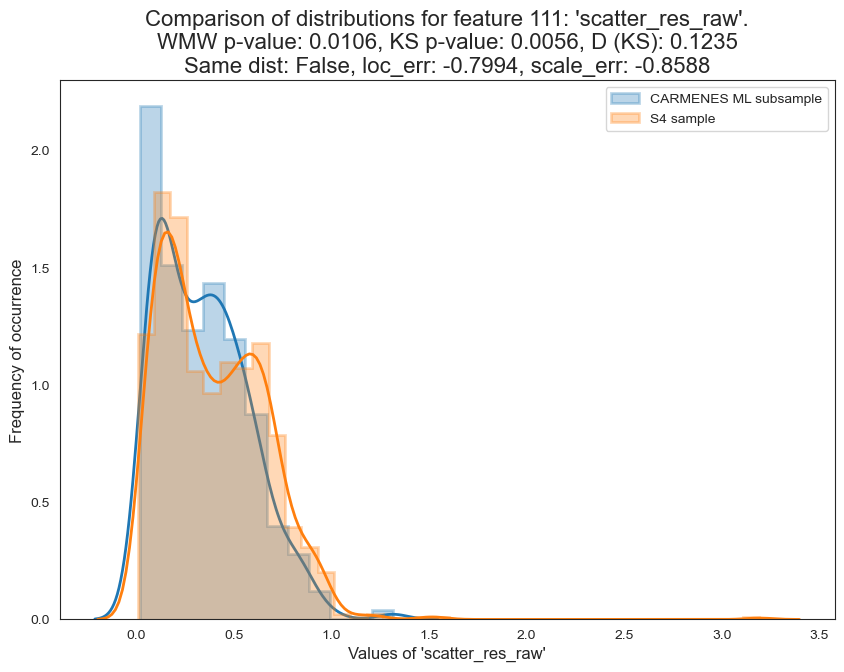

In [193]:
num_features = len(ml_s4_comp)
for i in range(0, num_features):
    clear_output(wait=True)
    feature_id = ml_s4_comp.loc[i, 'Feature_ID']
    feature = ml_s4_comp.loc[i, 'Feature']
    img_filename = DIST_IMG_FOLDER_1 + "FE_20_" + feature_id + "_" + feature + "_Dist_comparison.jpg"
    img_title = "Comparison of distributions for feature " + feature_id + ": '" + feature + "'.\n" \
        "WMW p-value: %.4f, KS p-value: %.4f, D (KS): %.4f\nSame dist: %s, loc_err: %.4f, scale_err: %.4f" \
        %(ml_s4_comp.loc[i, 'WMW_pvalue'], ml_s4_comp.loc[i, 'KS_pvalue'], ml_s4_comp.loc[i, 'KS_D'], \
          ml_s4_comp.loc[i, 'Same distribution'], \
          ml_s4_comp.loc[i, 'loc_rel_error'], ml_s4_comp.loc[i, 'scale_rel_error']) 
    compare_dist(d1=ml[feature], d2=s4[feature],
                 d1_label=ID_0, d2_label=ID_4,
                 varname="Values of '" + feature + "'",
                 fig_title=img_title, kde=True,
                 fig_filename=img_filename)
    plt.show();
#compare_dist(d1, d2, d1_label, d2_label, varname=None, fig_title=None, fig_filename=None, kde=False, conf_level=0.95):

**OBSERVATION:** reviewing all the saved plots, we have seen important differences for many of the features (which was probably the first intuition with the results yielded by Wilcoxon-Mann-Whitney U test and Kolmogorov-Smirnov test.

However, **what is the cause for these discrepancies? We can think of two reasons for that:**

- The synthetic samples creation procedure is somehow flawed, so that S4 sample does not mimic the ML subsample characteristics well enough. If this is the case, and if this _"wrong features"_ features high in the feature importance ranking, we should discard them from the ML model training. This could be due to the following causes:
  - The statistical distributions we used to create the synthetic samples for pulsation amplitudes and frequencies are not the correct ones.
  - The ranges of such initial statistical distributions are wrong.
  - The error recreation procedure is wrong.
  - Other possible sources of error (for example, some unknown reliationship between sampling patterns and errors that we have not taken into account).
- The chosen prior for the ratio of pulsating stars is an incorrect assumption, and the different ratios of pulsation stars in ML subsample and S4 sample are the root cause for the differences in distirbutions for these features. If this is the case, there should be no problem at all, we could go ahead woth training the ML model using all features, and it should be expected that the features for which larger discrepancies are observed will be the ones more relevant to the pulsation /non-pulsation decision by the ML model (feature importance).

To try to see which could be the case, we will now plot and store similar figures, but this time including also the distributions for only the pulsating stars in S4 and for only the non-pulsating stars in S4.

#### ML subsample versus S4 sample versus only pulsating vs only non-pulsating

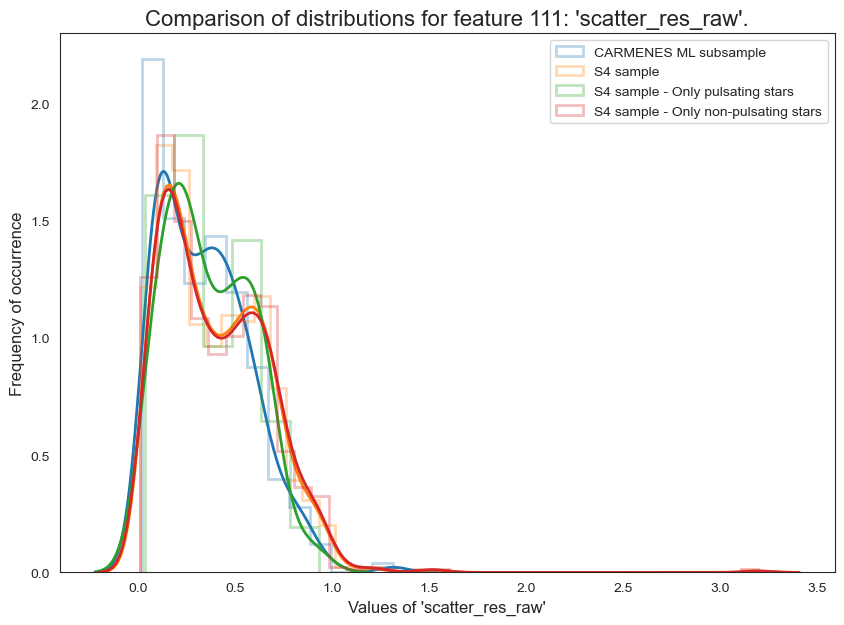

In [194]:
hist = False
kde = True
hist_fill = False
num_features = len(ml_s4_comp)
for i in range(0, num_features):
    clear_output(wait=True)
    feature_id = ml_s4_comp.loc[i, 'Feature_ID']
    feature = ml_s4_comp.loc[i, 'Feature']
    img_filename = DIST_IMG_FOLDER_2 + "FE_20_Complete_" + feature_id + "_" + feature + "_Dist_comparison.jpg"
    img_title = "Comparison of distributions for feature " + feature_id + ": '" + feature + "'." 
    multi_compare_dist(d_list=[ml[feature], s4[feature], s4p[feature], s4np[feature]],
                 d_labels=[ID_0, ID_4, ID_4P, ID_4NP],
                 varname="Values of '" + feature + "'",
                 fig_title=img_title, kde=kde, hist=hist, hist_fill=hist_fill,
                 fig_filename=img_filename)
    plt.show();

#multi_compare_dist_2(d_list, d_labels, varname=None, fig_title=None, fig_filename=None,
#                         kde=False, hist=False, hist_fill=True):

#### S4 pulsating stars vs S4 non-pulsating stars

Wilcoxon-Mann-Whitley U test results:
	Probably the same distribution: U=44413.000, p-value=0.435
	Probably the same distribution: D=0.108, p-value=0.213


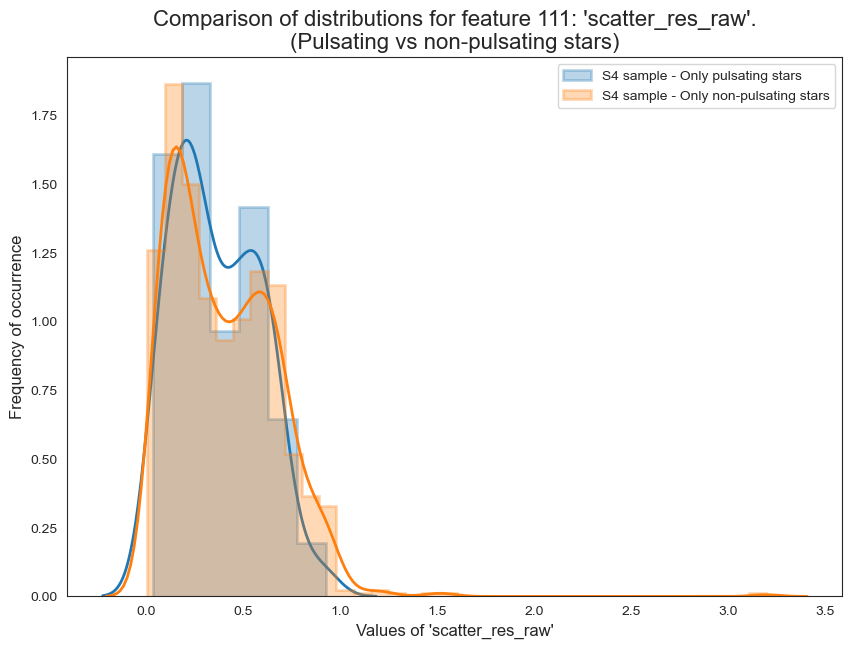

In [195]:
num_features = len(ml_s4_comp)
for i in range(0, num_features):
    clear_output(wait=True)
    feature_id = ml_s4_comp.loc[i, 'Feature_ID']
    feature = ml_s4_comp.loc[i, 'Feature']
    img_filename = DIST_IMG_FOLDER_3 + "FE_20_P-NP_" + feature_id + "_" + feature + "_Dist_comparison.jpg"
    img_title = "Comparison of distributions for feature " + feature_id + ": '" + feature + "'.\n" \
        "(Pulsating vs non-pulsating stars)"
    compare_dist(d1=s4p[feature], d2=s4np[feature],
                 d1_label=ID_4P, d2_label=ID_4NP,
                 varname="Values of '" + feature + "'",
                 fig_title=img_title, kde=True,
                 fig_filename=img_filename)
    plt.show();
#compare_dist(d1, d2, d1_label, d2_label, varname=None, fig_title=None, fig_filename=None, kde=False, conf_level=0.95):

**IMPORTANT OBSERVATION:** Once reviewed all the plots, the difference in distributions for amny features between ML subsample and S4 sample **cannot be fully expained by diferences in distributions between pulsating and non-pulsating stars**, hence, we could discard the chosen percentage of pulsators as a cause of this discrepancies.

## Correlation matrices between pairs of features

We now compute the correlation matrices for each pair of features, both for MS subsample and for S4 sample, with the aim to see if the interrelations between pairs of features are similar in both cases. We will also visually compare those matrices between the pulsating and non-pulsating stars subsamples of S4.

For each correlation matrix, we will put the Pearson's correlation coefficient (\href{https://en.wikipedia.org/wiki/Pearson_correlation_coefficient}) above the diagonal, and the Spearman's rank correlation coefficient (\href{https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient}) below the diagonal, so as to have additional, not-repeated information in one shot. Notice that Spearman's rank correlation coefficient is less sensitive to outliers in the tails of both samples.

We will support the numbers visually by means of heatmaps.

### Correlation matrices for ML subsample

#### Pearson's correlation matrix (ML)

In [196]:
p_corr_ml = ml[ALL_CS_FEATURES].corr(method='pearson')
p_corr_ml

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.436957,-0.424330,-0.167239,-0.270292,-0.177550,-0.292301,-0.379606,-0.256074,-0.392551,...,-0.282233,0.067950,0.052618,0.091837,-0.135524,-0.017167,-0.202089,-0.218745,-0.091213,0.018386
all_times_nhist_peak1_bin,-0.436957,1.000000,0.159047,-0.108177,0.007255,0.092195,0.009228,0.060687,-0.040938,0.024579,...,0.202604,-0.203902,-0.044349,-0.052728,0.085426,-0.015361,0.078786,0.123279,0.014055,-0.166433
all_times_nhist_peak2_bin,-0.424330,0.159047,1.000000,0.174776,0.035784,0.080958,0.124925,0.098146,0.130626,0.117276,...,0.230376,-0.154277,-0.001155,0.003478,0.132754,-0.127546,0.122629,0.049942,0.109333,-0.097836
all_times_nhist_peak3_bin,-0.167239,-0.108177,0.174776,1.000000,0.113692,0.033300,0.063747,0.197726,0.042424,0.189989,...,0.005310,-0.025992,0.056651,-0.122468,0.081292,-0.172712,0.128706,0.109402,0.045255,-0.017159
all_times_nhist_peak4_bin,-0.270292,0.007255,0.035784,0.113692,1.000000,-0.016574,0.108541,0.079659,0.139099,0.111812,...,-0.014667,0.112558,-0.012524,0.030145,-0.084348,-0.012561,0.063008,0.070307,0.107009,0.102194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.017167,-0.015361,-0.127546,-0.172712,-0.012561,-0.038832,0.002058,0.023650,0.072816,0.074111,...,-0.091216,0.163246,-0.086565,0.046931,0.080393,1.000000,-0.177776,0.045164,-0.564231,0.222549
p2p_scatter_over_mad,-0.202089,0.078786,0.122629,0.128706,0.063008,-0.036281,-0.039133,-0.046075,-0.007966,0.074108,...,0.419302,0.016858,0.010353,-0.762243,0.020435,-0.177776,1.000000,0.893677,0.432626,0.221924
p2p_scatter_pfold_over_mad,-0.218745,0.123279,0.049942,0.109402,0.070307,-0.027153,-0.036931,-0.059565,-0.019791,0.056291,...,0.370937,0.135237,-0.005731,-0.829465,-0.008292,0.045164,0.893677,1.000000,0.260321,0.354196
p2p_ssqr_diff_over_var,-0.091213,0.014055,0.109333,0.045255,0.107009,-0.087278,-0.100146,-0.111333,-0.065697,-0.096230,...,0.438192,-0.147670,0.129035,-0.199871,0.016635,-0.564231,0.432626,0.260321,1.000000,-0.144219


##### Pearson's correlation heatmap (ML)

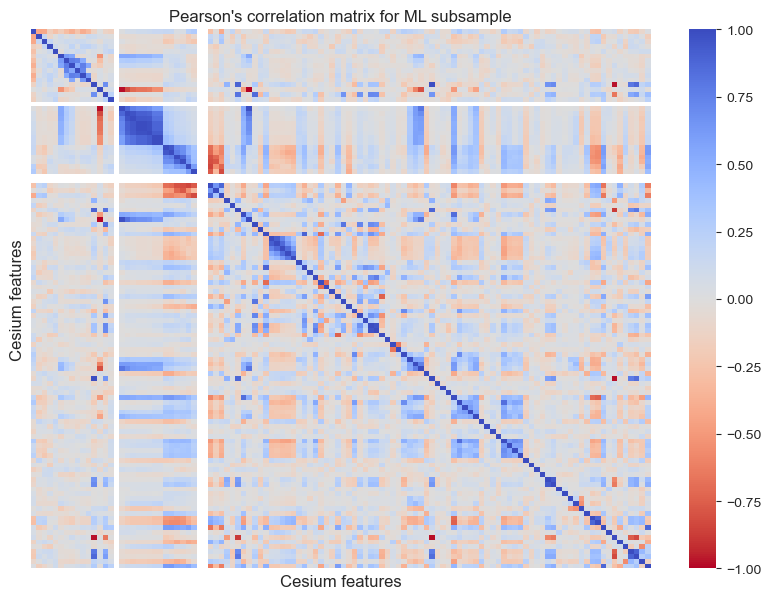

In [197]:
fig_title = "Pearson's correlation matrix for ML subsample"
img_file = IMG_FOLDER + "FE_20_01_Cesium_Pearson_ML.jpg"
draw_heatmap(p_corr_ml, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Spearman's rank correlation matrix (ML)

In [198]:
s_corr_ml = ml[ALL_CS_FEATURES].corr(method='spearman')
s_corr_ml

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.398145,-0.412441,-0.194598,-0.301539,-0.245866,-0.368057,-0.473514,-0.208903,-0.444946,...,-0.219681,0.070109,0.032489,0.097564,-0.089604,-0.010624,-0.113196,-0.135840,-0.051332,0.057444
all_times_nhist_peak1_bin,-0.398145,1.000000,0.154512,-0.043487,0.026654,0.155995,0.081663,0.076476,0.044853,0.112570,...,0.163809,-0.158640,-0.021473,-0.054716,0.064780,-0.063375,0.007635,0.024235,-0.004567,-0.158962
all_times_nhist_peak2_bin,-0.412441,0.154512,1.000000,0.185093,0.038815,0.083574,0.173137,0.173547,0.147477,0.152204,...,0.194362,-0.133500,-0.000981,-0.029979,0.030099,-0.172716,0.205613,0.025398,0.108195,-0.088737
all_times_nhist_peak3_bin,-0.194598,-0.043487,0.185093,1.000000,0.117441,0.081026,0.020192,0.140087,-0.103463,0.135335,...,-0.035544,-0.034141,0.063749,0.043142,0.065169,-0.149986,0.069916,-0.024350,0.049456,-0.032378
all_times_nhist_peak4_bin,-0.301539,0.026654,0.038815,0.117441,1.000000,0.058662,0.069559,0.045542,0.060573,0.027382,...,-0.079434,0.104614,0.008461,0.060086,-0.071932,0.040321,0.064924,0.070208,0.077857,0.111200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.010624,-0.063375,-0.172716,-0.149986,0.040321,-0.091622,-0.043678,-0.007981,0.028008,0.056659,...,-0.158708,0.271558,-0.076947,0.081315,-0.050953,1.000000,-0.400396,0.322494,-0.642902,0.341579
p2p_scatter_over_mad,-0.113196,0.007635,0.205613,0.069916,0.064924,-0.138781,-0.057891,-0.105106,-0.033226,-0.015576,...,0.396327,-0.137710,0.010096,-0.137590,0.129818,-0.400396,1.000000,0.370147,0.592977,-0.083150
p2p_scatter_pfold_over_mad,-0.135840,0.024235,0.025398,-0.024350,0.070208,-0.141466,-0.083026,-0.106581,-0.039906,-0.010495,...,0.154994,0.176203,-0.073360,-0.079836,0.004927,0.322494,0.370147,1.000000,-0.006201,0.329025
p2p_ssqr_diff_over_var,-0.051332,-0.004567,0.108195,0.049456,0.077857,-0.024984,-0.031226,-0.078613,-0.123603,-0.067883,...,0.347546,-0.174480,0.159982,-0.140452,-0.009369,-0.642902,0.592977,-0.006201,1.000000,-0.216517


##### Spearman's correlation heatmap (ML)

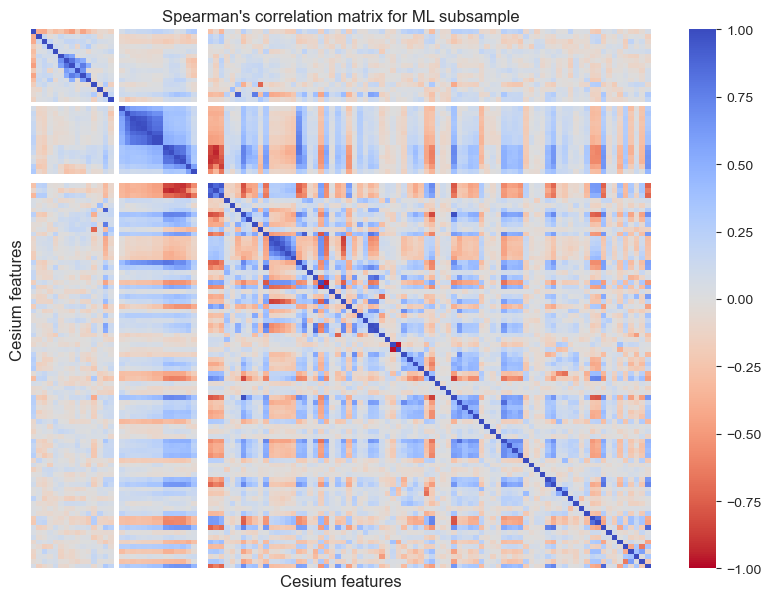

In [199]:
fig_title = "Spearman's correlation matrix for ML subsample"
img_file = IMG_FOLDER + "FE_20_02_Cesium_Spearman_ML.jpg"
draw_heatmap(s_corr_ml, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Combined correlation matrix (ML)

In [200]:
p_corr_ml.columns

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [201]:
p_corr_ml.index

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [202]:
np_corr_ml = np.triu(p_corr_ml, k=1) + np.tril(s_corr_ml, k=-1) + np.identity(len(p_corr_ml.columns))
np_corr_ml

array([[ 1.        , -0.43695702, -0.42433024, ..., -0.2187446 ,
        -0.09121323,  0.01838618],
       [-0.39814501,  1.        ,  0.15904692, ...,  0.12327937,
         0.01405531, -0.16643324],
       [-0.41244124,  0.15451237,  1.        , ...,  0.04994221,
         0.10933299, -0.097836  ],
       ...,
       [-0.13584007,  0.02423466,  0.02539751, ...,  1.        ,
         0.2603213 ,  0.3541961 ],
       [-0.05133206, -0.00456687,  0.10819522, ..., -0.0062006 ,
         1.        , -0.14421876],
       [ 0.057444  , -0.15896238, -0.08873735, ...,  0.32902536,
        -0.21651715,  1.        ]])

In [203]:
# Convert to pandas:
corr_ml = pd.DataFrame(data=np_corr_ml, index=p_corr_ml.index, columns=p_corr_ml.columns)
corr_ml

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.436957,-0.424330,-0.167239,-0.270292,-0.177550,-0.292301,-0.379606,-0.256074,-0.392551,...,-0.282233,0.067950,0.052618,0.091837,-0.135524,-0.017167,-0.202089,-0.218745,-0.091213,0.018386
all_times_nhist_peak1_bin,-0.398145,1.000000,0.159047,-0.108177,0.007255,0.092195,0.009228,0.060687,-0.040938,0.024579,...,0.202604,-0.203902,-0.044349,-0.052728,0.085426,-0.015361,0.078786,0.123279,0.014055,-0.166433
all_times_nhist_peak2_bin,-0.412441,0.154512,1.000000,0.174776,0.035784,0.080958,0.124925,0.098146,0.130626,0.117276,...,0.230376,-0.154277,-0.001155,0.003478,0.132754,-0.127546,0.122629,0.049942,0.109333,-0.097836
all_times_nhist_peak3_bin,-0.194598,-0.043487,0.185093,1.000000,0.113692,0.033300,0.063747,0.197726,0.042424,0.189989,...,0.005310,-0.025992,0.056651,-0.122468,0.081292,-0.172712,0.128706,0.109402,0.045255,-0.017159
all_times_nhist_peak4_bin,-0.301539,0.026654,0.038815,0.117441,1.000000,-0.016574,0.108541,0.079659,0.139099,0.111812,...,-0.014667,0.112558,-0.012524,0.030145,-0.084348,-0.012561,0.063008,0.070307,0.107009,0.102194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.010624,-0.063375,-0.172716,-0.149986,0.040321,-0.091622,-0.043678,-0.007981,0.028008,0.056659,...,-0.158708,0.271558,-0.076947,0.081315,-0.050953,1.000000,-0.177776,0.045164,-0.564231,0.222549
p2p_scatter_over_mad,-0.113196,0.007635,0.205613,0.069916,0.064924,-0.138781,-0.057891,-0.105106,-0.033226,-0.015576,...,0.396327,-0.137710,0.010096,-0.137590,0.129818,-0.400396,1.000000,0.893677,0.432626,0.221924
p2p_scatter_pfold_over_mad,-0.135840,0.024235,0.025398,-0.024350,0.070208,-0.141466,-0.083026,-0.106581,-0.039906,-0.010495,...,0.154994,0.176203,-0.073360,-0.079836,0.004927,0.322494,0.370147,1.000000,0.260321,0.354196
p2p_ssqr_diff_over_var,-0.051332,-0.004567,0.108195,0.049456,0.077857,-0.024984,-0.031226,-0.078613,-0.123603,-0.067883,...,0.347546,-0.174480,0.159982,-0.140452,-0.009369,-0.642902,0.592977,-0.006201,1.000000,-0.144219


##### Check if Pearson's values and Spearman's values are similar (tolerance = 0.1)

In [204]:
np.allclose(corr_ml, corr_ml.T, atol=0.1)

False

In [205]:
isclose_ml = np.isclose(corr_ml, corr_ml.T, atol=0.1).flatten()
isclose_ml

array([ True,  True,  True, ...,  True,  True,  True])

In [206]:
len(isclose_ml)

12544

In [207]:
len(isclose_ml[isclose_ml == False])

4588

##### Combined correlation heatmap (ML)

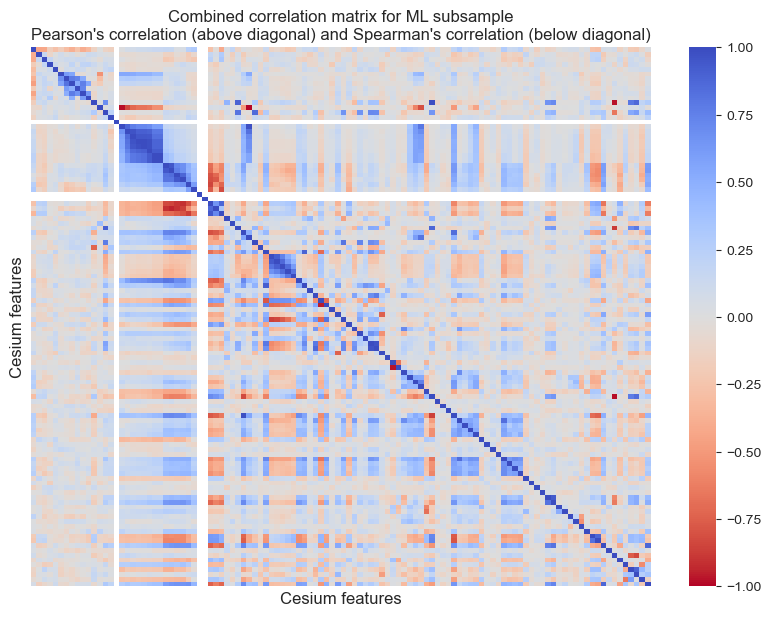

In [208]:
fig_title = "Combined correlation matrix for ML subsample\n" \
    "Pearson's correlation (above diagonal) and Spearman's correlation (below diagonal)"
img_file = IMG_FOLDER + "FE_20_03_Cesium_CombinedCorr_ML.jpg"
draw_heatmap(corr_ml, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

### Correlation matrices for S4 sample

#### Pearson's correlation matrix (S4)

In [209]:
p_corr_s4 = s4[ALL_CS_FEATURES].corr(method='pearson')
p_corr_s4

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.427080,-0.407424,-0.215594,-0.269108,-0.173845,-0.274391,-0.371591,-0.239627,-0.395950,...,-0.256149,0.208343,0.002559,0.095514,-0.088943,-0.077441,-0.147727,-0.129744,-0.125361,0.113561
all_times_nhist_peak1_bin,-0.427080,1.000000,0.137242,-0.136967,0.018468,0.123394,-0.000671,0.077439,-0.069742,0.016018,...,0.062391,-0.228431,0.024358,-0.060638,0.019974,-0.039532,0.082588,0.045587,0.088044,-0.194978
all_times_nhist_peak2_bin,-0.407424,0.137242,1.000000,0.179451,0.005723,0.038429,0.082631,0.067079,0.109221,0.112970,...,0.191034,-0.261809,-0.042214,-0.000500,0.092947,0.036528,0.093734,0.064497,0.034036,-0.195839
all_times_nhist_peak3_bin,-0.215594,-0.136967,0.179451,1.000000,0.128629,0.057372,0.084620,0.211051,0.054461,0.197512,...,0.012385,-0.045909,0.007979,-0.092466,-0.016669,-0.066286,0.050371,0.028726,-0.015611,-0.021544
all_times_nhist_peak4_bin,-0.269108,0.018468,0.005723,0.128629,1.000000,-0.043422,0.093993,0.048420,0.122853,0.091145,...,0.016480,0.025527,-0.020546,-0.044891,-0.050729,0.052655,-0.063382,0.029535,-0.101200,0.040269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.077441,-0.039532,0.036528,-0.066286,0.052655,-0.064161,-0.002610,-0.022625,0.051873,0.031921,...,0.192030,0.031284,0.032927,-0.039582,0.429303,1.000000,-0.019150,0.217229,-0.430453,0.121328
p2p_scatter_over_mad,-0.147727,0.082588,0.093734,0.050371,-0.063382,0.024901,-0.007607,-0.016764,-0.007230,0.015360,...,0.240478,-0.022652,0.003892,0.049268,0.017037,-0.019150,1.000000,0.825150,0.320485,0.133360
p2p_scatter_pfold_over_mad,-0.129744,0.045587,0.064497,0.028726,0.029535,-0.007142,-0.014384,-0.042203,-0.000748,0.000590,...,0.295666,0.049439,-0.008220,0.040694,0.031235,0.217229,0.825150,1.000000,0.116703,0.345030
p2p_ssqr_diff_over_var,-0.125361,0.088044,0.034036,-0.015611,-0.101200,0.104455,0.026619,0.041640,-0.019382,-0.000480,...,0.179246,-0.010653,-0.048351,-0.034614,-0.075138,-0.430453,0.320485,0.116703,1.000000,-0.006329


##### Pearson's correlation heatmap (S4)

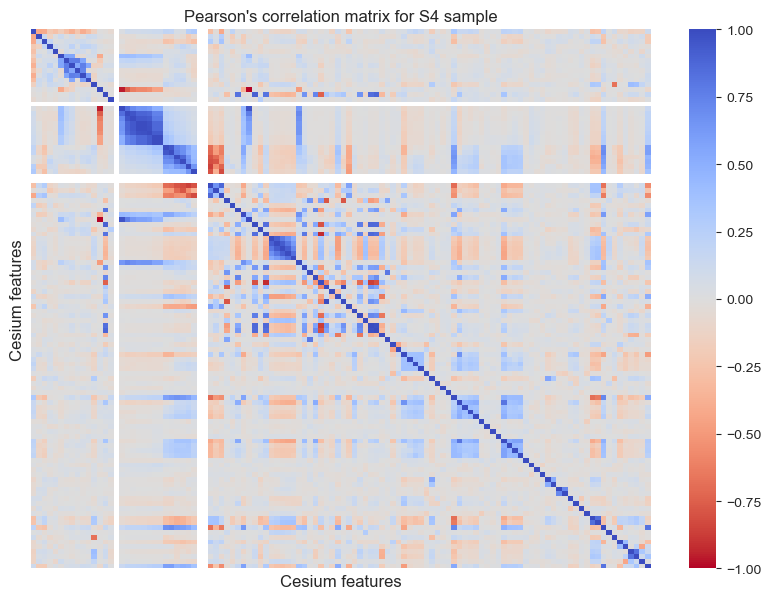

In [210]:
fig_title = "Pearson's correlation matrix for S4 sample"
img_file = IMG_FOLDER + "FE_20_04_Cesium_Pearson_S4.jpg"
draw_heatmap(p_corr_s4, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Spearman's rank correlation matrix (S4)

In [211]:
s_corr_s4 = s4[ALL_CS_FEATURES].corr(method='spearman')
s_corr_s4

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.397410,-0.392406,-0.244111,-0.293384,-0.204242,-0.336087,-0.451083,-0.175933,-0.421113,...,-0.190131,0.198330,0.000633,0.047352,-0.108646,-0.079441,-0.119929,-0.072286,-0.066943,0.152771
all_times_nhist_peak1_bin,-0.397410,1.000000,0.142426,-0.089263,0.039765,0.145778,0.053261,0.061866,0.030310,0.095344,...,0.011077,-0.185635,0.019191,0.005126,0.059435,-0.070271,0.064863,-0.023404,0.046038,-0.164788
all_times_nhist_peak2_bin,-0.392406,0.142426,1.000000,0.186449,0.001382,0.051905,0.142391,0.154579,0.153144,0.151626,...,0.158117,-0.238400,-0.041365,-0.010041,0.112936,0.006231,0.082601,-0.014224,-0.021504,-0.214433
all_times_nhist_peak3_bin,-0.244111,-0.089263,0.186449,1.000000,0.127026,0.096955,0.047416,0.162801,-0.105827,0.131587,...,-0.027228,-0.043567,0.013889,0.013340,-0.002061,-0.064204,0.030357,-0.022877,-0.013362,-0.023841
all_times_nhist_peak4_bin,-0.293384,0.039765,0.001382,0.127026,1.000000,0.021224,0.003344,0.005454,0.023868,-0.007101,...,-0.027391,0.035724,0.015061,-0.022080,-0.030235,0.061676,-0.031397,0.018322,-0.115346,0.034768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.079441,-0.070271,0.006231,-0.064204,0.061676,-0.129449,-0.023379,0.006390,0.047915,0.057767,...,0.096646,0.278958,0.028848,-0.025108,-0.003754,1.000000,-0.076110,0.388519,-0.445812,0.302636
p2p_scatter_over_mad,-0.119929,0.064863,0.082601,0.030357,-0.031397,-0.005929,0.006399,-0.027145,-0.014634,-0.000417,...,0.087977,-0.052933,-0.000564,-0.019773,0.042413,-0.076110,1.000000,0.384742,0.340429,0.061823
p2p_scatter_pfold_over_mad,-0.072286,-0.023404,-0.014224,-0.022877,0.018322,-0.060738,0.001321,-0.000672,0.043184,0.043723,...,0.107405,0.275271,-0.061102,-0.030913,0.017617,0.388519,0.384742,1.000000,0.018114,0.394221
p2p_ssqr_diff_over_var,-0.066943,0.046038,-0.021504,-0.013362,-0.115346,0.097216,0.070617,0.069406,-0.026112,0.026197,...,0.069399,0.006899,-0.059250,-0.006358,0.006586,-0.445812,0.340429,0.018114,1.000000,-0.001297


##### Spearman's correlation heatmap (S4)

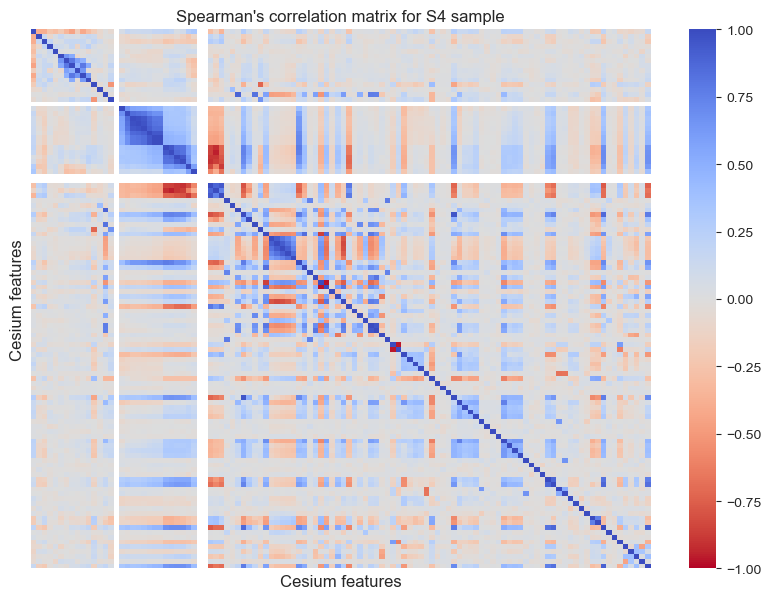

In [212]:
fig_title = "Spearman's correlation matrix for S4 sample"
img_file = IMG_FOLDER + "FE_20_05_Cesium_Spearman_S4.jpg"
draw_heatmap(s_corr_s4, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Combined correlation matrix (S4)

In [213]:
p_corr_s4.columns

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [214]:
p_corr_s4.index

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [215]:
np_corr_s4 = np.triu(p_corr_s4, k=1) + np.tril(s_corr_s4, k=-1) + np.identity(len(p_corr_s4.columns))
np_corr_s4

array([[ 1.        , -0.42708048, -0.40742383, ..., -0.12974437,
        -0.12536073,  0.11356149],
       [-0.39740973,  1.        ,  0.13724247, ...,  0.04558671,
         0.08804436, -0.19497789],
       [-0.39240585,  0.1424262 ,  1.        , ...,  0.06449748,
         0.03403616, -0.19583932],
       ...,
       [-0.07228572, -0.02340382, -0.01422391, ...,  1.        ,
         0.11670338,  0.34502954],
       [-0.06694341,  0.04603763, -0.02150418, ...,  0.01811377,
         1.        , -0.00632918],
       [ 0.15277148, -0.16478804, -0.2144328 , ...,  0.39422063,
        -0.00129658,  1.        ]])

In [216]:
# Convert to pandas:
corr_s4 = pd.DataFrame(data=np_corr_s4, index=p_corr_s4.index, columns=p_corr_s4.columns)
corr_s4

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.427080,-0.407424,-0.215594,-0.269108,-0.173845,-0.274391,-0.371591,-0.239627,-0.395950,...,-0.256149,0.208343,0.002559,0.095514,-0.088943,-0.077441,-0.147727,-0.129744,-0.125361,0.113561
all_times_nhist_peak1_bin,-0.397410,1.000000,0.137242,-0.136967,0.018468,0.123394,-0.000671,0.077439,-0.069742,0.016018,...,0.062391,-0.228431,0.024358,-0.060638,0.019974,-0.039532,0.082588,0.045587,0.088044,-0.194978
all_times_nhist_peak2_bin,-0.392406,0.142426,1.000000,0.179451,0.005723,0.038429,0.082631,0.067079,0.109221,0.112970,...,0.191034,-0.261809,-0.042214,-0.000500,0.092947,0.036528,0.093734,0.064497,0.034036,-0.195839
all_times_nhist_peak3_bin,-0.244111,-0.089263,0.186449,1.000000,0.128629,0.057372,0.084620,0.211051,0.054461,0.197512,...,0.012385,-0.045909,0.007979,-0.092466,-0.016669,-0.066286,0.050371,0.028726,-0.015611,-0.021544
all_times_nhist_peak4_bin,-0.293384,0.039765,0.001382,0.127026,1.000000,-0.043422,0.093993,0.048420,0.122853,0.091145,...,0.016480,0.025527,-0.020546,-0.044891,-0.050729,0.052655,-0.063382,0.029535,-0.101200,0.040269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.079441,-0.070271,0.006231,-0.064204,0.061676,-0.129449,-0.023379,0.006390,0.047915,0.057767,...,0.096646,0.278958,0.028848,-0.025108,-0.003754,1.000000,-0.019150,0.217229,-0.430453,0.121328
p2p_scatter_over_mad,-0.119929,0.064863,0.082601,0.030357,-0.031397,-0.005929,0.006399,-0.027145,-0.014634,-0.000417,...,0.087977,-0.052933,-0.000564,-0.019773,0.042413,-0.076110,1.000000,0.825150,0.320485,0.133360
p2p_scatter_pfold_over_mad,-0.072286,-0.023404,-0.014224,-0.022877,0.018322,-0.060738,0.001321,-0.000672,0.043184,0.043723,...,0.107405,0.275271,-0.061102,-0.030913,0.017617,0.388519,0.384742,1.000000,0.116703,0.345030
p2p_ssqr_diff_over_var,-0.066943,0.046038,-0.021504,-0.013362,-0.115346,0.097216,0.070617,0.069406,-0.026112,0.026197,...,0.069399,0.006899,-0.059250,-0.006358,0.006586,-0.445812,0.340429,0.018114,1.000000,-0.006329


##### Combined correlation heatmap (S4)

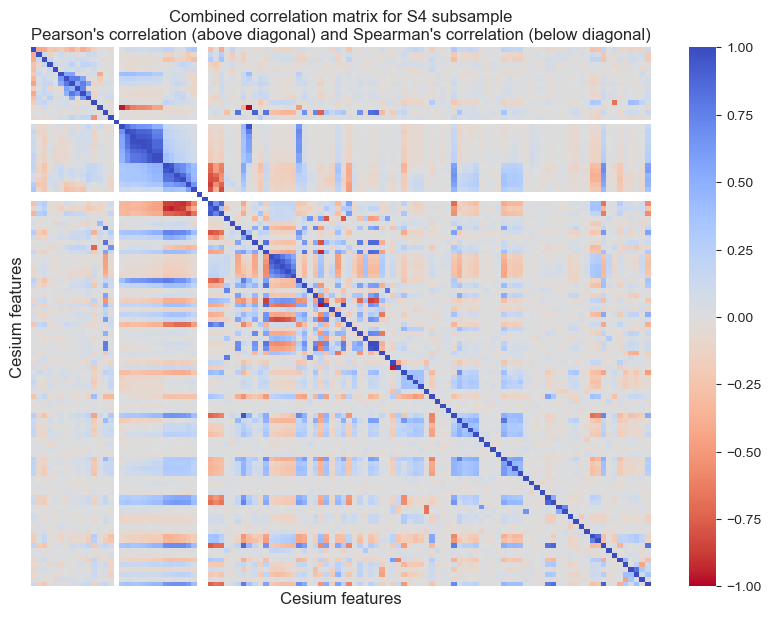

In [217]:
fig_title = "Combined correlation matrix for S4 subsample\n" \
    "Pearson's correlation (above diagonal) and Spearman's correlation (below diagonal)"
img_file = IMG_FOLDER + "FE_20_06_Cesium_CombinedCorr_S4.jpg"
draw_heatmap(corr_s4, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

### Correlation matrices for pulsating stars in S4

#### Pearson's correlation matrix (pulsating in S4)

In [218]:
p_corr_s4p = s4p[ALL_CS_FEATURES].corr(method='pearson')
p_corr_s4p

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.398214,-0.419705,-0.125956,-0.226365,-0.230770,-0.362575,-0.326103,-0.270039,-0.333682,...,-0.376562,0.193827,-0.005610,-0.116053,-0.066571,-0.158980,-0.264928,-0.262434,-0.230393,0.086763
all_times_nhist_peak1_bin,-0.398214,1.000000,0.096849,-0.386588,0.016603,0.284854,0.052998,-0.034579,-0.195737,-0.188047,...,0.183008,-0.212662,0.094035,0.187363,-0.088886,0.073037,0.138053,0.188363,0.108734,-0.176211
all_times_nhist_peak2_bin,-0.419705,0.096849,1.000000,0.261238,-0.040889,-0.028778,0.129623,0.094316,0.191024,0.180537,...,0.278919,-0.224989,-0.020247,0.020726,0.079244,0.101194,0.337433,0.234190,-0.013258,-0.159868
all_times_nhist_peak3_bin,-0.125956,-0.386588,0.261238,1.000000,0.207302,-0.115569,0.055394,0.227235,0.183610,0.275440,...,-0.027881,-0.093256,0.040253,-0.020819,-0.053248,-0.149900,-0.134760,-0.149374,-0.074799,-0.056338
all_times_nhist_peak4_bin,-0.226365,0.016603,-0.040889,0.207302,1.000000,-0.137087,-0.039924,-0.068501,0.011050,0.012241,...,-0.039844,0.048221,-0.043617,-0.063101,-0.070169,0.103214,0.048147,0.191317,-0.060779,0.048126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.158980,0.073037,0.101194,-0.149900,0.103214,-0.165980,-0.119787,-0.180466,-0.005595,-0.034991,...,0.370368,0.062264,-0.179375,0.016114,0.218357,1.000000,0.373277,0.606371,-0.231674,0.164451
p2p_scatter_over_mad,-0.264928,0.138053,0.337433,-0.134760,0.048147,0.064963,0.098833,-0.159840,0.030324,-0.157680,...,0.331858,-0.176119,-0.073334,0.011097,0.206358,0.373277,1.000000,0.785041,0.310686,-0.038561
p2p_scatter_pfold_over_mad,-0.262434,0.188363,0.234190,-0.149374,0.191317,0.072027,0.092284,-0.103342,0.042909,-0.096096,...,0.376902,-0.114490,-0.118157,0.224542,0.189339,0.606371,0.785041,1.000000,0.121758,0.082848
p2p_ssqr_diff_over_var,-0.230393,0.108734,-0.013258,-0.074799,-0.060779,0.077065,0.004665,-0.056808,-0.059323,-0.129603,...,0.315345,-0.061275,0.042990,0.122638,-0.171305,-0.231674,0.310686,0.121758,1.000000,-0.026226


##### Pearson's correlation heatmap (pulsating in S4)

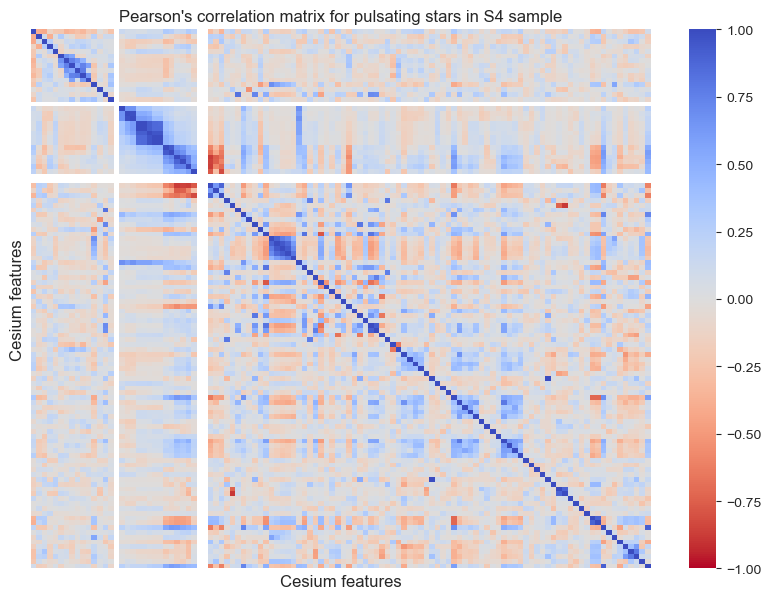

In [219]:
fig_title = "Pearson's correlation matrix for pulsating stars in S4 sample"
img_file = IMG_FOLDER + "FE_20_07_Cesium_Pearson_Pulsating.jpg"
draw_heatmap(p_corr_s4p, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Spearman's rank correlation matrix (pulsating in S4)

In [220]:
s_corr_s4p = s4p[ALL_CS_FEATURES].corr(method='spearman')
s_corr_s4p

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.379453,-0.419487,-0.170214,-0.274371,-0.218185,-0.378560,-0.356559,-0.201335,-0.326854,...,-0.312365,0.180297,-0.005559,-0.046522,-0.043973,-0.084606,-0.234306,-0.196855,-0.283685,0.086147
all_times_nhist_peak1_bin,-0.379453,1.000000,0.139505,-0.339273,0.060448,0.276982,0.093443,-0.091929,-0.078465,-0.108136,...,0.176797,-0.153723,0.044899,0.015803,-0.047920,0.041306,0.059044,0.000246,0.148844,-0.119507
all_times_nhist_peak2_bin,-0.419487,0.139505,1.000000,0.268517,-0.039287,0.000399,0.109602,0.156608,0.118605,0.207215,...,0.283617,-0.206863,0.010416,0.049744,0.097575,0.033661,0.283098,0.045347,0.022387,-0.153970
all_times_nhist_peak3_bin,-0.170214,-0.339273,0.268517,1.000000,0.215630,-0.176183,-0.074833,0.149610,0.023558,0.244071,...,-0.067217,-0.074533,0.007762,0.028316,-0.039393,-0.120268,-0.112484,-0.074821,-0.087709,-0.038443
all_times_nhist_peak4_bin,-0.274371,0.060448,-0.039287,0.215630,1.000000,-0.091596,-0.141352,-0.031873,-0.003954,0.009291,...,-0.103697,0.056500,-0.013164,-0.081606,0.047475,0.119507,0.016294,0.174583,-0.123634,0.064076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.084606,0.041306,0.033661,-0.120268,0.119507,-0.263700,-0.186840,-0.158949,-0.086260,-0.050997,...,0.249440,0.182652,-0.150752,-0.100117,0.065869,1.000000,0.038216,0.314424,-0.334130,0.252278
p2p_scatter_over_mad,-0.234306,0.059044,0.283098,-0.112484,0.016294,0.094969,-0.010901,-0.196362,-0.066345,-0.251143,...,0.135315,-0.038835,-0.030684,-0.035176,0.112468,0.038216,1.000000,0.442037,0.390138,0.106343
p2p_scatter_pfold_over_mad,-0.196855,0.000246,0.045347,-0.074821,0.174583,0.061285,0.025495,-0.092551,-0.070427,-0.126657,...,0.206028,0.118959,-0.266105,0.099061,0.102227,0.314424,0.442037,1.000000,0.142153,0.307980
p2p_ssqr_diff_over_var,-0.283685,0.148844,0.022387,-0.087709,-0.123634,0.154236,0.140154,0.019729,0.000720,-0.030423,...,0.169113,-0.041886,0.034034,0.097845,-0.061176,-0.334130,0.390138,0.142153,1.000000,-0.000544


##### Spearman's correlation heatmap (pulsating in S4)

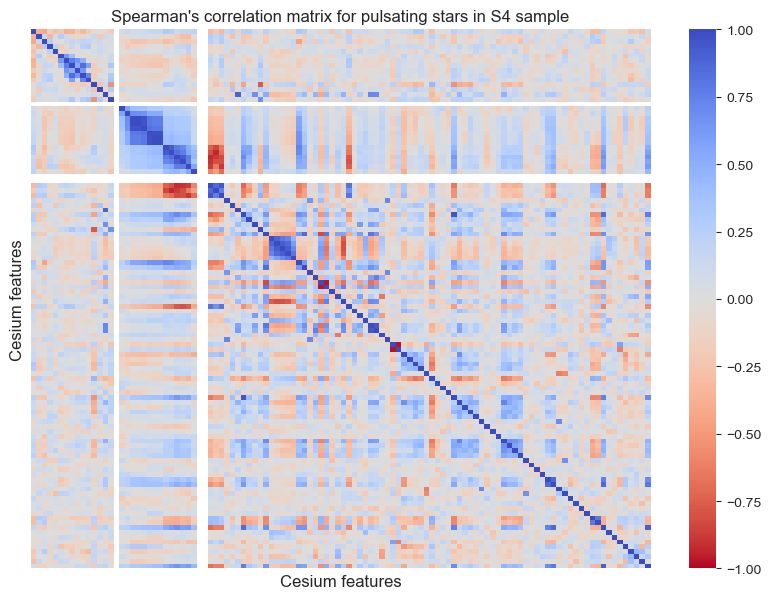

In [221]:
fig_title = "Spearman's correlation matrix for pulsating stars in S4 sample"
img_file = IMG_FOLDER + "FE_20_08_Cesium_Spearman_Pulsating.jpg"
draw_heatmap(s_corr_s4p, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Combined correlation matrix (pulsating S4)

In [222]:
p_corr_s4p.columns

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [223]:
p_corr_s4p.index

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [224]:
np_corr_s4p = np.triu(p_corr_s4p, k=1) + np.tril(s_corr_s4p, k=-1) + np.identity(len(p_corr_s4p.columns))
np_corr_s4p

array([[ 1.00000000e+00, -3.98213561e-01, -4.19705431e-01, ...,
        -2.62434471e-01, -2.30393365e-01,  8.67634626e-02],
       [-3.79452905e-01,  1.00000000e+00,  9.68485695e-02, ...,
         1.88362976e-01,  1.08733766e-01, -1.76211218e-01],
       [-4.19487471e-01,  1.39505077e-01,  1.00000000e+00, ...,
         2.34190154e-01, -1.32580170e-02, -1.59867756e-01],
       ...,
       [-1.96855176e-01,  2.45581613e-04,  4.53466333e-02, ...,
         1.00000000e+00,  1.21757680e-01,  8.28484989e-02],
       [-2.83684566e-01,  1.48843812e-01,  2.23874954e-02, ...,
         1.42152993e-01,  1.00000000e+00, -2.62257556e-02],
       [ 8.61473011e-02, -1.19507487e-01, -1.53969684e-01, ...,
         3.07980369e-01, -5.44116078e-04,  1.00000000e+00]])

In [225]:
# Convert to pandas:
corr_s4p = pd.DataFrame(data=np_corr_s4p, index=p_corr_s4p.index, columns=p_corr_s4p.columns)
corr_s4p

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.398214,-0.419705,-0.125956,-0.226365,-0.230770,-0.362575,-0.326103,-0.270039,-0.333682,...,-0.376562,0.193827,-0.005610,-0.116053,-0.066571,-0.158980,-0.264928,-0.262434,-0.230393,0.086763
all_times_nhist_peak1_bin,-0.379453,1.000000,0.096849,-0.386588,0.016603,0.284854,0.052998,-0.034579,-0.195737,-0.188047,...,0.183008,-0.212662,0.094035,0.187363,-0.088886,0.073037,0.138053,0.188363,0.108734,-0.176211
all_times_nhist_peak2_bin,-0.419487,0.139505,1.000000,0.261238,-0.040889,-0.028778,0.129623,0.094316,0.191024,0.180537,...,0.278919,-0.224989,-0.020247,0.020726,0.079244,0.101194,0.337433,0.234190,-0.013258,-0.159868
all_times_nhist_peak3_bin,-0.170214,-0.339273,0.268517,1.000000,0.207302,-0.115569,0.055394,0.227235,0.183610,0.275440,...,-0.027881,-0.093256,0.040253,-0.020819,-0.053248,-0.149900,-0.134760,-0.149374,-0.074799,-0.056338
all_times_nhist_peak4_bin,-0.274371,0.060448,-0.039287,0.215630,1.000000,-0.137087,-0.039924,-0.068501,0.011050,0.012241,...,-0.039844,0.048221,-0.043617,-0.063101,-0.070169,0.103214,0.048147,0.191317,-0.060779,0.048126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.084606,0.041306,0.033661,-0.120268,0.119507,-0.263700,-0.186840,-0.158949,-0.086260,-0.050997,...,0.249440,0.182652,-0.150752,-0.100117,0.065869,1.000000,0.373277,0.606371,-0.231674,0.164451
p2p_scatter_over_mad,-0.234306,0.059044,0.283098,-0.112484,0.016294,0.094969,-0.010901,-0.196362,-0.066345,-0.251143,...,0.135315,-0.038835,-0.030684,-0.035176,0.112468,0.038216,1.000000,0.785041,0.310686,-0.038561
p2p_scatter_pfold_over_mad,-0.196855,0.000246,0.045347,-0.074821,0.174583,0.061285,0.025495,-0.092551,-0.070427,-0.126657,...,0.206028,0.118959,-0.266105,0.099061,0.102227,0.314424,0.442037,1.000000,0.121758,0.082848
p2p_ssqr_diff_over_var,-0.283685,0.148844,0.022387,-0.087709,-0.123634,0.154236,0.140154,0.019729,0.000720,-0.030423,...,0.169113,-0.041886,0.034034,0.097845,-0.061176,-0.334130,0.390138,0.142153,1.000000,-0.026226


##### Combined correlation heatmap (pulsating S4)

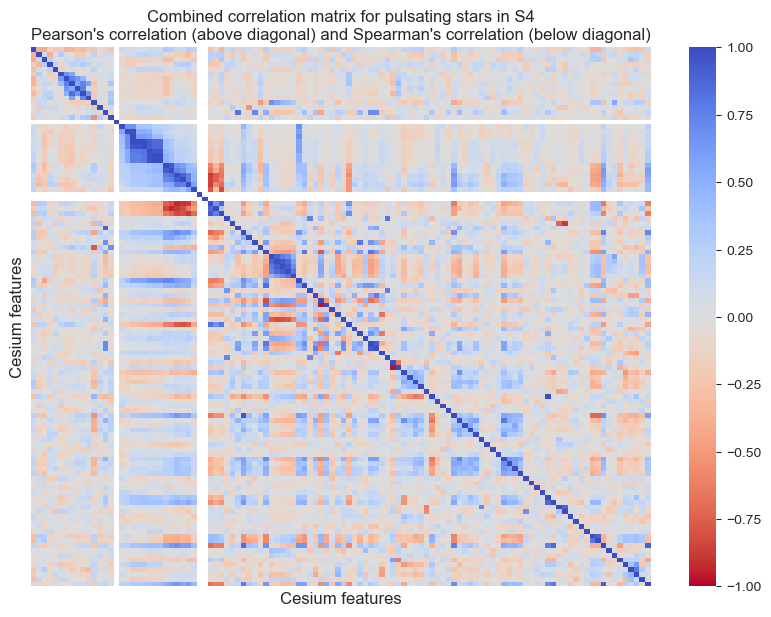

In [226]:
fig_title = "Combined correlation matrix for pulsating stars in S4\n" \
    "Pearson's correlation (above diagonal) and Spearman's correlation (below diagonal)"
img_file = IMG_FOLDER + "FE_20_09_Cesium_CombinedCorr_Pulsating.jpg"
draw_heatmap(corr_s4p, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

### Correlation matrices for non-pulsating stars in S4

#### Pearson's correlation matrix (non-pulsating in S4)

In [227]:
p_corr_s4np = s4np[ALL_CS_FEATURES].corr(method='pearson')
p_corr_s4np

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.428808,-0.407774,-0.228996,-0.271861,-0.167910,-0.265715,-0.376063,-0.237679,-0.403398,...,-0.241816,0.208099,0.003871,0.106463,-0.092307,-0.073253,-0.137943,-0.118741,-0.110355,0.114424
all_times_nhist_peak1_bin,-0.428808,1.000000,0.143993,-0.101713,0.015446,0.105173,-0.008157,0.089914,-0.058977,0.042351,...,0.046543,-0.228181,0.014566,-0.073405,0.030850,-0.047367,0.077570,0.032381,0.083420,-0.195510
all_times_nhist_peak2_bin,-0.407774,0.143993,1.000000,0.169164,0.012232,0.045503,0.078427,0.064838,0.102336,0.105864,...,0.179855,-0.266931,-0.044788,-0.000758,0.094046,0.031466,0.073133,0.050116,0.040979,-0.200464
all_times_nhist_peak3_bin,-0.228996,-0.101713,0.169164,1.000000,0.119890,0.076840,0.088094,0.209235,0.042916,0.187138,...,0.017967,-0.041602,0.003724,-0.097583,-0.014247,-0.060670,0.068488,0.045843,-0.006185,-0.018970
all_times_nhist_peak4_bin,-0.271861,0.015446,0.012232,0.119890,1.000000,-0.034374,0.105671,0.060187,0.132061,0.098848,...,0.024583,0.025967,-0.018314,-0.043497,-0.048595,0.052658,-0.073040,0.021822,-0.109992,0.042221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.073253,-0.047367,0.031466,-0.060670,0.052658,-0.057358,0.005237,-0.010755,0.055629,0.040359,...,0.179047,0.028138,0.050857,-0.040450,0.439634,1.000000,-0.041189,0.195423,-0.453302,0.117969
p2p_scatter_over_mad,-0.137943,0.077570,0.073133,0.068488,-0.073040,0.021799,-0.015769,-0.002542,-0.009988,0.035160,...,0.233438,-0.010579,0.011119,0.050631,0.006317,-0.041189,1.000000,0.827750,0.324238,0.145386
p2p_scatter_pfold_over_mad,-0.118741,0.032381,0.050116,0.045843,0.021822,-0.013312,-0.022403,-0.037766,-0.003848,0.009494,...,0.289889,0.062291,0.002045,0.036676,0.022209,0.195423,0.827750,1.000000,0.117186,0.363188
p2p_ssqr_diff_over_var,-0.110355,0.083420,0.040979,-0.006185,-0.109992,0.108111,0.028828,0.055938,-0.015653,0.020285,...,0.159474,-0.003461,-0.061823,-0.042668,-0.067265,-0.453302,0.324238,0.117186,1.000000,-0.003228


##### Pearson's correlation heatmap (non-pulsating in S4)

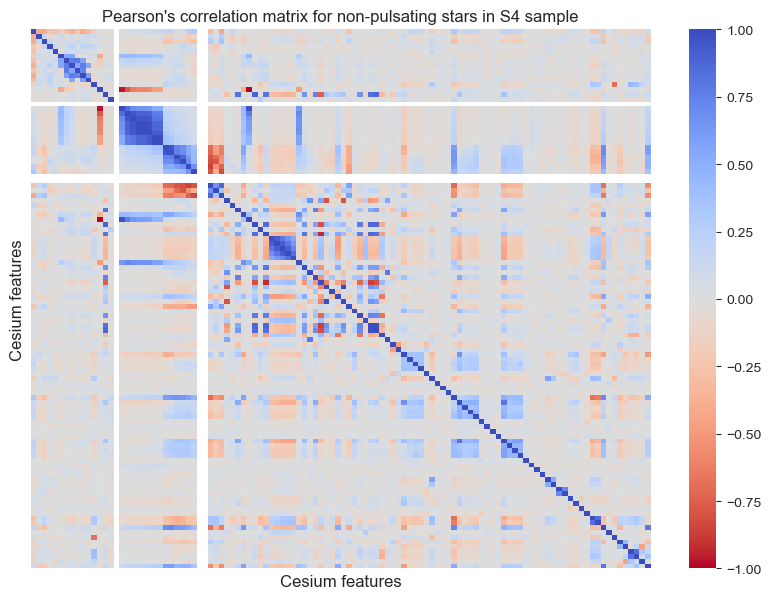

In [228]:
fig_title = "Pearson's correlation matrix for non-pulsating stars in S4 sample"
img_file = IMG_FOLDER + "FE_20_10_Cesium_Pearson_Non-pulsating.jpg"
draw_heatmap(p_corr_s4np, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Spearman's rank correlation matrix (non-pulsating in S4)

In [229]:
s_corr_s4np = s4np[ALL_CS_FEATURES].corr(method='spearman')
s_corr_s4np

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.396098,-0.392288,-0.254496,-0.293066,-0.202314,-0.328648,-0.458323,-0.171258,-0.430027,...,-0.176304,0.194977,0.005698,0.057496,-0.116803,-0.082870,-0.108973,-0.062740,-0.042142,0.155706
all_times_nhist_peak1_bin,-0.396098,1.000000,0.143131,-0.057665,0.034472,0.130822,0.045454,0.075957,0.043238,0.118091,...,-0.005785,-0.187137,0.012448,0.004291,0.074659,-0.081191,0.066083,-0.023078,0.034744,-0.167402
all_times_nhist_peak2_bin,-0.392288,0.143131,1.000000,0.178427,0.007053,0.058792,0.150201,0.157140,0.158602,0.146483,...,0.143625,-0.242627,-0.050174,-0.015562,0.114185,0.005186,0.059113,-0.019203,-0.026850,-0.219018
all_times_nhist_peak3_bin,-0.254496,-0.057665,0.178427,1.000000,0.118880,0.130573,0.063832,0.165129,-0.120205,0.117476,...,-0.021945,-0.040490,0.015036,0.012740,0.002034,-0.056623,0.047928,-0.015030,-0.004077,-0.021511
all_times_nhist_peak4_bin,-0.293066,0.034472,0.007053,0.118880,1.000000,0.031769,0.016438,0.006479,0.028093,-0.012334,...,-0.016907,0.035971,0.014724,-0.016918,-0.035199,0.059602,-0.036497,0.003780,-0.116586,0.034140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.082870,-0.081191,0.005186,-0.056623,0.059602,-0.115733,-0.001343,0.026322,0.066374,0.071783,...,0.078742,0.289938,0.048075,-0.014724,-0.013551,1.000000,-0.087728,0.396027,-0.457736,0.309150
p2p_scatter_over_mad,-0.108973,0.066083,0.059113,0.047928,-0.036497,-0.016875,0.007386,-0.007959,-0.008207,0.029724,...,0.081623,-0.054563,0.002386,-0.019068,0.035928,-0.087728,1.000000,0.379495,0.332971,0.058624
p2p_scatter_pfold_over_mad,-0.062740,-0.023078,-0.019203,-0.015030,0.003780,-0.074289,-0.001318,0.012971,0.060304,0.066638,...,0.093857,0.292731,-0.035196,-0.045246,0.005214,0.396027,0.379495,1.000000,0.003055,0.405074
p2p_ssqr_diff_over_var,-0.042142,0.034744,-0.026850,-0.004077,-0.116586,0.090238,0.058474,0.074276,-0.030763,0.033443,...,0.058423,0.013956,-0.071163,-0.017602,0.015737,-0.457736,0.332971,0.003055,1.000000,-0.002106


##### Spearman's correlation heatmap (non-pulsating in S4)

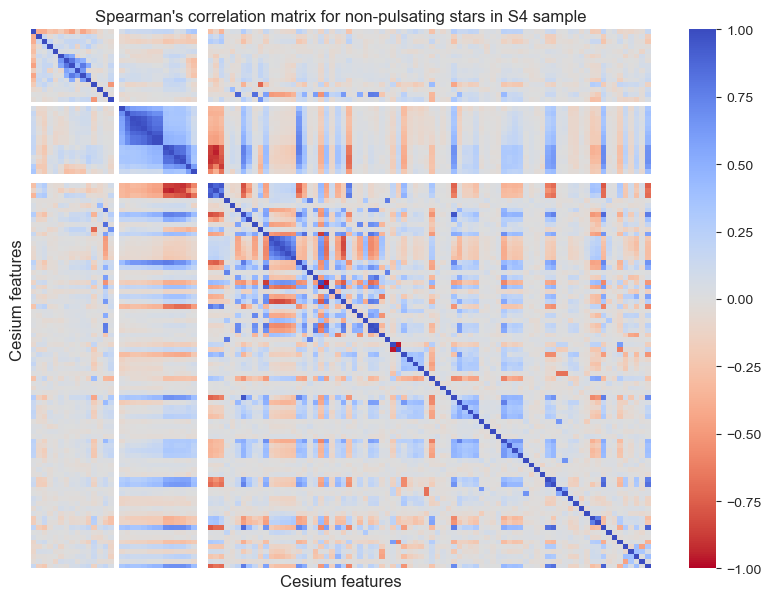

In [230]:
fig_title = "Spearman's correlation matrix for non-pulsating stars in S4 sample"
img_file = IMG_FOLDER + "FE_20_11_Cesium_Spearman_Non-pulsating.jpg"
draw_heatmap(s_corr_s4np, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

#### Combined correlation matrix (non-pulsating S4)

In [231]:
p_corr_s4np.columns

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [232]:
p_corr_s4np.index

Index(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       ...
       'freq_signif_ratio_31', 'freq_varrat', 'freq_y_offset', 'linear_trend',
       'medperc90_2p_p', 'p2p_scatter_2praw', 'p2p_scatter_over_mad',
       'p2p_scatter_pfold_over_mad', 'p2p_ssqr_diff_over_var',
       'scatter_res_raw'],
      dtype='object', length=112)

In [233]:
np_corr_s4np = np.triu(p_corr_s4np, k=1) + np.tril(s_corr_s4np, k=-1) + np.identity(len(p_corr_s4np.columns))
np_corr_s4np

array([[ 1.        , -0.42880842, -0.40777384, ..., -0.11874101,
        -0.11035494,  0.11442385],
       [-0.39609804,  1.        ,  0.14399289, ...,  0.03238118,
         0.08342027, -0.19551039],
       [-0.39228832,  0.14313087,  1.        , ...,  0.05011588,
         0.04097871, -0.20046434],
       ...,
       [-0.06273959, -0.02307826, -0.01920275, ...,  1.        ,
         0.1171863 ,  0.36318772],
       [-0.04214166,  0.0347436 , -0.02685047, ...,  0.00305477,
         1.        , -0.00322832],
       [ 0.15570585, -0.16740181, -0.21901756, ...,  0.40507431,
        -0.00210575,  1.        ]])

In [234]:
# Convert to pandas:
corr_s4np = pd.DataFrame(data=np_corr_s4np, index=p_corr_s4np.index, columns=p_corr_s4np.columns)
corr_s4np

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,1.000000,-0.428808,-0.407774,-0.228996,-0.271861,-0.167910,-0.265715,-0.376063,-0.237679,-0.403398,...,-0.241816,0.208099,0.003871,0.106463,-0.092307,-0.073253,-0.137943,-0.118741,-0.110355,0.114424
all_times_nhist_peak1_bin,-0.396098,1.000000,0.143993,-0.101713,0.015446,0.105173,-0.008157,0.089914,-0.058977,0.042351,...,0.046543,-0.228181,0.014566,-0.073405,0.030850,-0.047367,0.077570,0.032381,0.083420,-0.195510
all_times_nhist_peak2_bin,-0.392288,0.143131,1.000000,0.169164,0.012232,0.045503,0.078427,0.064838,0.102336,0.105864,...,0.179855,-0.266931,-0.044788,-0.000758,0.094046,0.031466,0.073133,0.050116,0.040979,-0.200464
all_times_nhist_peak3_bin,-0.254496,-0.057665,0.178427,1.000000,0.119890,0.076840,0.088094,0.209235,0.042916,0.187138,...,0.017967,-0.041602,0.003724,-0.097583,-0.014247,-0.060670,0.068488,0.045843,-0.006185,-0.018970
all_times_nhist_peak4_bin,-0.293066,0.034472,0.007053,0.118880,1.000000,-0.034374,0.105671,0.060187,0.132061,0.098848,...,0.024583,0.025967,-0.018314,-0.043497,-0.048595,0.052658,-0.073040,0.021822,-0.109992,0.042221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.082870,-0.081191,0.005186,-0.056623,0.059602,-0.115733,-0.001343,0.026322,0.066374,0.071783,...,0.078742,0.289938,0.048075,-0.014724,-0.013551,1.000000,-0.041189,0.195423,-0.453302,0.117969
p2p_scatter_over_mad,-0.108973,0.066083,0.059113,0.047928,-0.036497,-0.016875,0.007386,-0.007959,-0.008207,0.029724,...,0.081623,-0.054563,0.002386,-0.019068,0.035928,-0.087728,1.000000,0.827750,0.324238,0.145386
p2p_scatter_pfold_over_mad,-0.062740,-0.023078,-0.019203,-0.015030,0.003780,-0.074289,-0.001318,0.012971,0.060304,0.066638,...,0.093857,0.292731,-0.035196,-0.045246,0.005214,0.396027,0.379495,1.000000,0.117186,0.363188
p2p_ssqr_diff_over_var,-0.042142,0.034744,-0.026850,-0.004077,-0.116586,0.090238,0.058474,0.074276,-0.030763,0.033443,...,0.058423,0.013956,-0.071163,-0.017602,0.015737,-0.457736,0.332971,0.003055,1.000000,-0.003228


##### Combined correlation heatmap (non-pulsating S4)

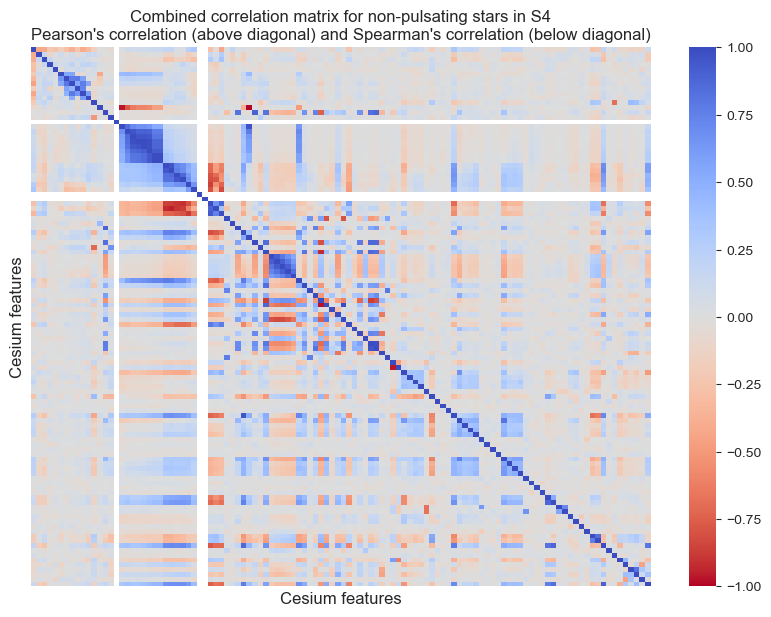

In [235]:
fig_title = "Combined correlation matrix for non-pulsating stars in S4\n" \
    "Pearson's correlation (above diagonal) and Spearman's correlation (below diagonal)"
img_file = IMG_FOLDER + "FE_20_12_Cesium_CombinedCorr_Non-pulsating.jpg"
draw_heatmap(corr_s4np, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

### Comparison: S4 sample and ML subsample

To see this, we will compute the element-wise subtraction of the two combined matrices.

In [236]:
ml_s4_corr_diff = np.subtract(corr_s4, corr_ml)
ml_s4_corr_diff

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,0.000000,0.009877,0.016906,-0.048354,0.001184,0.003705,0.017910,0.008014,0.016446,-0.003399,...,0.026084,0.140393,-0.050059,0.003676,0.046581,-0.060274,0.054362,0.089000,-0.034148,0.095175
all_times_nhist_peak1_bin,0.000735,0.000000,-0.021804,-0.028790,0.011213,0.031199,-0.009899,0.016752,-0.028804,-0.008560,...,-0.140212,-0.024529,0.068707,-0.007910,-0.065452,-0.024171,0.003802,-0.077693,0.073989,-0.028545
all_times_nhist_peak2_bin,0.020035,-0.012086,0.000000,0.004675,-0.030060,-0.042529,-0.042295,-0.031068,-0.021405,-0.004306,...,-0.039342,-0.107532,-0.041059,-0.003978,-0.039807,0.164074,-0.028896,0.014555,-0.075297,-0.098003
all_times_nhist_peak3_bin,-0.049513,-0.045776,0.001356,0.000000,0.014938,0.024072,0.020873,0.013326,0.012037,0.007523,...,0.007075,-0.019917,-0.048672,0.030002,-0.097961,0.106427,-0.078335,-0.080676,-0.060866,-0.004386
all_times_nhist_peak4_bin,0.008155,0.013111,-0.037433,0.009585,0.000000,-0.026847,-0.014548,-0.031239,-0.016246,-0.020666,...,0.031147,-0.087031,-0.008022,-0.075036,0.033618,0.065216,-0.126390,-0.040773,-0.208209,-0.061925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,-0.068817,-0.006896,0.178947,0.085782,0.021356,-0.037827,0.020299,0.014371,0.019906,0.001108,...,0.255354,0.007399,0.105795,-0.106422,0.047199,0.000000,0.158627,0.172065,0.133778,-0.101220
p2p_scatter_over_mad,-0.006733,0.057228,-0.123012,-0.039559,-0.096321,0.132852,0.064291,0.077961,0.018591,0.015159,...,-0.308350,0.084777,-0.010660,0.117816,-0.087405,0.324286,0.000000,-0.068526,-0.112141,-0.088564
p2p_scatter_pfold_over_mad,0.063554,-0.047638,-0.039621,0.001473,-0.051886,0.080728,0.084346,0.105909,0.083090,0.054217,...,-0.047590,0.099068,0.012258,0.048923,0.012690,0.066025,0.014595,0.000000,-0.143618,-0.009167
p2p_ssqr_diff_over_var,-0.015611,0.050604,-0.129699,-0.062818,-0.193203,0.122200,0.101843,0.148019,0.097491,0.094080,...,-0.278147,0.181379,-0.219232,0.134093,0.015956,0.197090,-0.252548,0.024314,0.000000,0.137890


In [237]:
ml_s4_corr_diff.describe().loc[['mean', 'std', 'min', 'max']]

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
mean,-0.000074,0.005424,-0.000932,0.016113,-0.035105,-0.001071,-0.001276,0.014906,-0.006829,0.018388,...,0.009295,-0.014933,-0.006581,0.048876,0.006795,-0.023860,-0.005824,-0.024131,0.035447,-0.030434
std,0.070213,0.057015,0.067356,0.070247,0.068295,0.047409,0.057394,0.069212,0.048328,0.069104,...,0.143142,0.131085,0.067587,0.174514,0.078410,0.127262,0.169091,0.176968,0.143844,0.140471
min,-0.195746,-0.216400,-0.178958,-0.156982,-0.225990,-0.149073,-0.147261,-0.152858,-0.149316,-0.149380,...,-0.366194,-0.499348,-0.264789,-0.338317,-0.253618,-0.322136,-0.645478,-0.727850,-0.312565,-0.535071
max,0.154846,0.147600,0.178947,0.198750,0.192900,0.132852,0.146519,0.198663,0.131938,0.163020,...,0.282852,0.305653,0.105795,0.896494,0.208862,0.348910,0.811512,0.870159,0.337996,0.344382


 #### Heatmap for comparison (S4 vs ML)

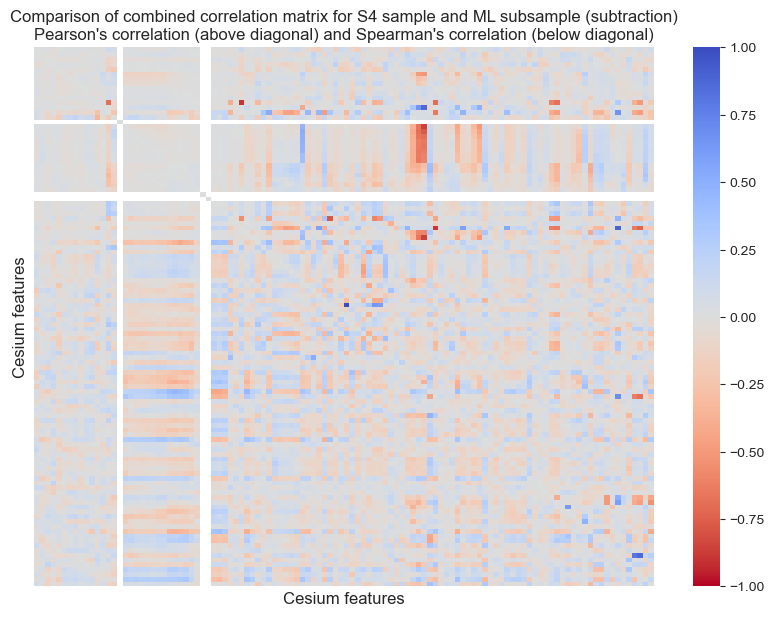

In [238]:
fig_title = "Comparison of combined correlation matrix for S4 sample and ML subsample (subtraction)\n" \
    "Pearson's correlation (above diagonal) and Spearman's correlation (below diagonal)"
img_file = IMG_FOLDER + "FE_20_13_Cesium_CombinedCorr_ComparisonDiff_S4_ML.jpg"
draw_heatmap(ml_s4_corr_diff, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

### Comparison: pulsating and non-pulsating stars in S4 sample

To see this, we will compute the element-wise subtraction of the two combined matrices.

In [239]:
p_np_corr_diff = np.subtract(corr_s4np, corr_s4p)
p_np_corr_diff

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
all_times_nhist_numpeaks,0.000000,-0.030595,0.011932,-0.103040,-0.045496,0.062859,0.096860,-0.049960,0.032359,-0.069716,...,0.134746,0.014272,0.009481,0.222515,-0.025736,0.085727,0.126985,0.143693,0.120038,0.027660
all_times_nhist_peak1_bin,-0.016645,0.000000,0.047144,0.284875,-0.001157,-0.179680,-0.061155,0.124493,0.136760,0.230398,...,-0.136465,-0.015519,-0.079468,-0.260768,0.119736,-0.120404,-0.060483,-0.155982,-0.025313,-0.019299
all_times_nhist_peak2_bin,0.027199,0.003626,0.000000,-0.092074,0.053121,0.074280,-0.051197,-0.029478,-0.088688,-0.074674,...,-0.099063,-0.041942,-0.024541,-0.021485,0.014801,-0.069728,-0.264300,-0.184074,0.054237,-0.040597
all_times_nhist_peak3_bin,-0.084283,0.281608,-0.090091,0.000000,-0.087412,0.192410,0.032699,-0.018000,-0.140694,-0.088303,...,0.045848,0.051654,-0.036528,-0.076764,0.039001,0.089231,0.203248,0.195217,0.068613,0.037368
all_times_nhist_peak4_bin,-0.018694,-0.025976,0.046340,-0.096750,0.000000,0.102712,0.145595,0.128688,0.121011,0.086606,...,0.064427,-0.022253,0.025303,0.019604,0.021574,-0.050556,-0.121187,-0.169496,-0.049213,-0.005905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p2p_scatter_2praw,0.001736,-0.122496,-0.028474,0.063645,-0.059905,0.147968,0.185496,0.185271,0.152634,0.122779,...,-0.170697,0.107286,0.198827,0.085394,-0.079420,0.000000,-0.414466,-0.410948,-0.221628,-0.046482
p2p_scatter_over_mad,0.125333,0.007040,-0.223986,0.160411,-0.052791,-0.111844,0.018286,0.188403,0.058138,0.280867,...,-0.053692,-0.015728,0.033070,0.016108,-0.076540,-0.125944,0.000000,0.042710,0.013552,0.183947
p2p_scatter_pfold_over_mad,0.134116,-0.023324,-0.064549,0.059791,-0.170803,-0.135574,-0.026813,0.105522,0.130732,0.193294,...,-0.112171,0.173772,0.230908,-0.144308,-0.097013,0.081602,-0.062542,0.000000,-0.004571,0.280339
p2p_ssqr_diff_over_var,0.241543,-0.114100,-0.049238,0.083632,0.007049,-0.063998,-0.081680,0.054547,-0.031483,0.063866,...,-0.110690,0.055842,-0.105197,-0.115447,0.076912,-0.123606,-0.057167,-0.139098,0.000000,0.022997


In [240]:
p_np_corr_diff.describe()

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,-0.005390,0.001084,0.002125,-0.012427,-0.023836,0.035606,0.037187,0.040453,0.017751,0.022310,...,0.001696,-0.001162,-0.006553,-0.015325,0.025486,0.025434,0.036388,0.034997,0.002373,-0.004158
std,0.089624,0.102037,0.088350,0.099701,0.091134,0.110180,0.097078,0.109096,0.082894,0.095688,...,0.108624,0.093019,0.107921,0.191336,0.077975,0.115300,0.133063,0.135552,0.121182,0.094627
min,-0.198066,-0.255691,-0.223986,-0.213922,-0.248164,-0.216863,-0.222169,-0.260352,-0.174448,-0.166580,...,-0.289147,-0.210767,-0.291060,-1.244103,-0.116699,-0.242707,-0.414466,-0.410948,-0.302067,-0.217400
25%,-0.072830,-0.068110,-0.060733,-0.090769,-0.087412,-0.042131,-0.016943,-0.055768,-0.042555,-0.038916,...,-0.064634,-0.063492,-0.071694,-0.076764,-0.031123,-0.054491,-0.047719,-0.060987,-0.049618,-0.065475
50%,0.001563,-0.012119,0.010265,-0.022974,-0.029936,0.046817,0.039656,0.039699,0.012323,0.016724,...,-0.012154,-0.005441,-0.016352,0.022516,0.039001,0.019750,0.053858,0.052079,0.020948,-0.005723
75%,0.048538,0.075769,0.054862,0.045273,0.023847,0.124913,0.103470,0.109675,0.070413,0.089627,...,0.072878,0.057012,0.048602,0.085394,0.076912,0.113983,0.116527,0.109698,0.089801,0.050616
max,0.241543,0.281608,0.229383,0.306756,0.257152,0.263065,0.288717,0.263576,0.234563,0.280867,...,0.295690,0.238384,0.306927,0.262555,0.229303,0.274170,0.311192,0.312068,0.228740,0.280339


 #### Heatmap for comparison (pulsating vs non.pulsating)

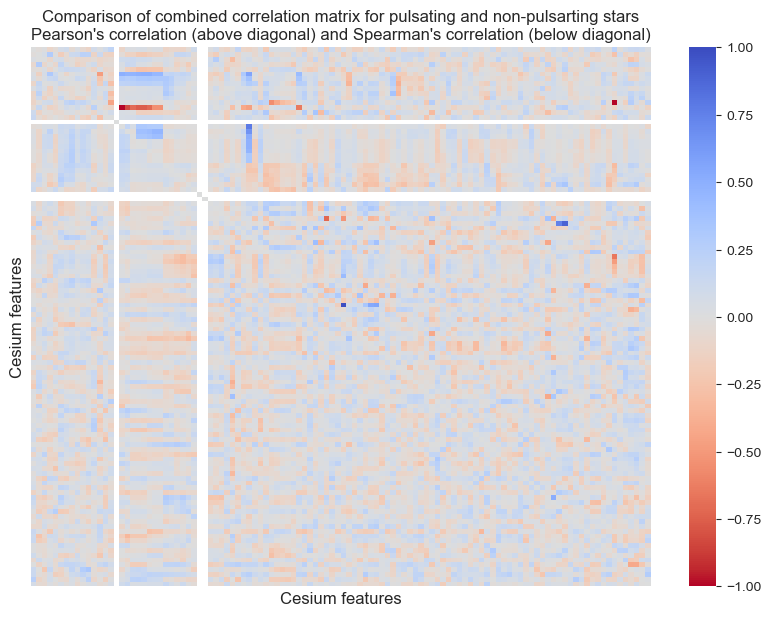

In [241]:
fig_title = "Comparison of combined correlation matrix for pulsating and non-pulsarting stars\n" \
    "Pearson's correlation (above diagonal) and Spearman's correlation (below diagonal)"
img_file = IMG_FOLDER + "FE_20_14_Cesium_CombinedCorr_ComparisonDiff_P_NP.jpg"
draw_heatmap(p_np_corr_diff, fig_title=fig_title,
             xlabel="Cesium features", ylabel="Cesium features",
             xsize=5, ysize=5,
             fig_filename=img_file,
             kwargs={'vmin': -1.0, 'vmax': 1.0,
                     'xticklabels': False, 'yticklabels': False, 'cmap': 'coolwarm_r'})

## Save the results to files

### Save the lists of features

#### Save the list of 'reliable' features

In [242]:
pickle.dump(rel_features, open(REL_FEATURES_LIST_OUT, 'wb'))

#### Save the list of 'unreliable' features

In [243]:
pickle.dump(unrel_features, open(UNREL_FEATURES_LIST_OUT, 'wb'))

### Save distribution comparisons

 #### Save the full results

In [244]:
ml_s4_comp.to_csv(RESULTS_FILE, sep=',', decimal='.', index=False)

#### Save only the _reliable_ features

In [245]:
all_pass.to_csv(RELIABLE_FEATURES_FILE, sep=',', decimal='.', index=False)

#### Save only the _unreliable_ features

In [246]:
any_fail.to_csv(UNRELIABLE_FEATURES_FILE, sep=',', decimal='.', index=False)

### Save the correlations and comparisons

#### Save the correlations for ML subsample

In [247]:
corr_ml.to_csv(CORR_ML_FILE, sep=',', decimal='.')

#### Save the correlations for S4 sample

In [248]:
corr_s4.to_csv(CORR_S4_FILE, sep=',', decimal='.')

#### Save the correlations for pulsating stars in S4

In [249]:
corr_s4p.to_csv(CORR_S4P_FILE, sep=',', decimal='.')

#### Save the correlations for non-pulsating stars in S4

In [250]:
corr_s4np.to_csv(CORR_S4NP_FILE, sep=',', decimal='.')

#### Save the comparison of correlations for ML subsample and S4 sample

In [251]:
ml_s4_corr_diff.to_csv(COMP_CORR_S4_ML_FILE, sep=',', decimal='.')

#### Save the comparison of correlations for pulsating and non-pulsating stars

In [252]:
p_np_corr_diff.to_csv(COMP_CORR_P_NP_FILE, sep=',', decimal='.')

## Summary

**CONCLUSIONS:**
- Completed the `cesium` feature comparative analysis between the ML subsample and the S4 sample, and between the pulsating and non-pulsating stars.
- Individual features distribution comparison: 
  - Found important discrepancies in features between the distributions of values for CARMENES ML subsample and S4 sample (about half of the features show large discrepancies in distributions).
  - Form many features, the distribution of values are very similar between the pulsating and non pulsating stars, and for those which have clear differences, such differences are subtle: this means that the classification algorithm is not going to have an easy task. 
- Comparison of features correlation pair-wise:
  - In general, the feature-to-feature correlation values are similar when comparing the ML subsample with the S4 sample. However, there are some few points and areas in the the correlation matrices which are very different. The different values affect primarily to the Pearson's correlation coefficient (which is more sensitive to outliers). In this case, different correlation values are a bad thing, because that suggests that ML subsample and S4 sample are not similar to each other.
  - For the comparison of pulsating and non-pulsating stars, once again the Pearson's coefficient is the most affected one. In general, the similarity is greater. Besides, the dissimilarity between these features is less that in the case of ML subsample / S4 sample. Also, the coordinates of the dissimilarity points are different from those in ML / S4 comparison (save for a few points), which is good. In this case, features which show different correlations between pulsating and non-pulsating would be a good thing, because it will indicate that the _cesium_ features are different for both type of objects, and hence the classification algorithm can focus on those features to make a decision.
- The different behaviour of features values between the ML subsample and the S4 sample would be a problem if the classification algorithm turns out to rely on the most divergent features to make the classification of pulsating / non pulsating. In that case, we will probably need to discard those features for the training of the model. On the contrary, if those "unreliable" features are automatically discarded or minimized by the classification algorithm itself, we can go ahead will all the features.
- Finally, we established two groups of features which we stored for later use: a set of **$48$ reliable features**; and a set of **$64$ unreliable features**.